# The Ising Model

## A bit of theory

The Ising model allows to study ferromagnetism and can be used to study what is known as a phase transition.

Take a piece of iron at room temperature and subject it to a strong magnetic field (either using a permanent magnet or an electromagnet). After a while, switch off the magnetic field. You will observe that the piece of iron now acts itself  like a magnet. This property is shared by ferromagnetic materials which are able to sustain a non-zero magnetisation without any external field. However, this property vanishes above a certain temperature. This temperature is called the Curie temperature $T_c$, and depends on the ferromagnetic material considered. For iron,  $T_c$ is 1043 K. In thermodynamic terms we say that the ferromagnetic material undergoes a phase transition at the critical temperature $T_c$ since its properties change abruptly at that temperature.


In the Ising model of ferromagnetism, the material considered is described using unit magnets, called dipoles, distributed on a regular lattice and that can either point upwards or downwards (see figure 1). These dipoles represent the atoms that constitute the material and act like magnets oriented in different directions.


<img src="./figures/lattice1.png" alt="Drawing" style="width: 300px;"/>
Figure 1

In the simplest version of the Ising model, all the dipoles interact with their nearest neighbors (left, right, above, below). When two neighbors are aligned, the system is in a more stable configuration than when they are aligned in opposite directions (you may observe a similar property if you put two compasses near each other). The energy of the system can then be written as,

$$
E=-J\sum_{pairs(i,j)} s_i s_j,
$$

where the sum runs over all the pairs of dipoles in the system and $s_i$ denotes the 'spin' of the $i$-th dipole which is equal to $1$ or $-1$ wether the dipole points upwards or downwards; $J>0$ is the coupling constant for each pair of dipoles. We thus see that the energy is minimized and equal to $-JN_{pairs}$ when all the dipoles point in the same direction. 

Each time a dipole is flipped, the energy changes by an amount equal to,

$$
\Delta E = -{J} s_i \sum_{j \in n(i)} s_j
$$

where $n(i)$ denotes all the neighbors of the $i$-th dipole. $\Delta E$ is positive or negative depending on the sign of $s_i$ and the total spin of the neighbors.

According to statistical mechanics, the probability of finding the system in a given configuration $X$ is equal to,

$$
p(X) = \frac{e^{-\beta E_X}}{Z}
$$

where $E_X$ is the potential energy of the configuration and $\beta=1/k_B T$ where $k_B$ is the so-called Boltzmann constant. In other words, the higher the potential energy, the less likely it is to find the system in the corresponding configuration. In the above formula $Z$ is a normalisation constant such that $\sum_X p(X)=1$,

$$
Z=\sum_X e^{-\beta E_X}.
$$

Knowing the probability of each state $X$ makes it possible to compute many quantities by simply performing averages (which is the whole idea behind statistical mechanics). For instance, the mean energy and the mean magnetisation are respectively,

$$
<E> = \frac{\sum_X E_X e^{-\beta E_X}}{Z}\\
<M> = \frac{\sum_X M_X e^{-\beta E_X}}{Z}
$$

with $M_X=\sum_{i=1}^N s_i$ for the given state. This quantity is particularly interesting as it is a signature for studying the phase transition. Above the Curie temperature, one has $<M>=0$ while $<M>$ has a finite non vanishing value below the Curie temperature.



## The Metropolis algorithm

Computing averages over all possible states poses a computational difficulty when the number of lattice points becomes large. For example, for a $100\times100$ lattice, the number of possible states is $2^{10000}$ which is a huge number and makes brut force computation impossible. Thankfully, we can rely on stochastic methods and use, for instance, the Metropolis Monte Carlo algorithm.

Let us consider an initial state in which each spin takes a random orientation. 
The unit step of the Metropolis algorithm consists in choosing a random spin and in attempting to change its orientation. If the energy of the reversed spin decreases, the flipped state is chosen as the new configuration of the system.
Otherwise if the energy increases by $\Delta E$, the flip is only accepted with the probability,

$$
p_{\rm flip}=e^{-\beta\Delta E},
$$

otherwise the current state is retained as the new configuration. This process is repeated until a large enough number of states $X_k$ has been collected.

The averages we are interested in, such as the energy or the magnetisation, are then computed according to,

$$
<E> = \frac{\sum_k E_k}{N_k}\\
<M> = \frac{\sum_k M_k}{N_k}
$$

where the sums run over all the states generated through the Metropolis algorithm and $N_k$ is the total number of them.

Compared to the averages over all possible states, we see here that we only sum over a subset of them. However, thanks to the Metropolis algorithm, the states corresponding to different values of the energy are generated with the right distribution function and the averages above converge to the equilibrium values as $N_k\rightarrow \infty$. Technically speaking, the (normed) histogram of the states generated with the Metropolis algorithm converges to the same histogram
obtained using the full set of states weighted with their Boltzmann factor.

### Verification

Instead of providing a formal proof that the Metropolis algorithm works, let us check this for a simplified system in which all the spins are fixed except at one location.

Before doing so, we first adopt a non-dimensional unit system. 
Initially, our ferromagnetism problem has two parameters: the temperature $T$ and the coupling constant $J$. However, if we adopt as energy unit the product $k_b T$, our model has only one free parameter $\alpha=J/(k_b T)$ and the relevant formulas read:

$$
\Delta E = -{\alpha} s_i \sum_{j \in n(i)} s_j \\
p_{\rm flip}=e^{-\Delta E}
$$

Any two materials at given temperatures can be described by the same equations as long as they have the same value of $\alpha$.

We first import a few libaries and load a $10\times 10$ initial state so that we all start from the same one.

In [2]:
%matplotlib inline
import numpy
from matplotlib import pyplot
from matplotlib import animation
import matplotlib.cm as cm
from JSAnimation.IPython_display import display_animation

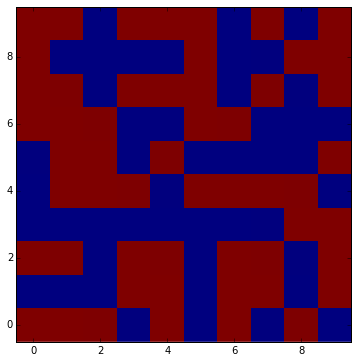

In [3]:
nx=10
ny=10

# Non-dimensional coupling constant J/(kb*T)
alpha = 0.1

# Initial spins at each site
sp = numpy.load('initial_state.npy')

pyplot.figure(figsize=(6,6))
pyplot.imshow(sp,interpolation="none",origin='lower')



Blue and red represent respectively sites that have their spins pointing down or up. Focus now the attention on the site with coordinates (x,y)=(5,5). It pointing down and has three neighbors pointing up and one pointing down.

We may compute the contribution to the energy coming from this site with the following subroutine (we assume that the system is periodic in both directions):

In [5]:
def energy_at_site(sp,alpha,sigma,ix,iy):
    """ Computes the contribution to the energy for a given spin
    at location ix,iy for a lattice with periodic boundary conditions
   
    Parameters:
    ----------
    sp: numpy array
        array of spins
    alpha  : real
        coupling constant J/(kb*T)
    sigma   : int
        spin at site ix,iy
    ix   : int
        location in x
    iy   : int
        location in y
    
   
    Returns:
    -------
    energy: energy for the given configuration
    """
    
    energy=-alpha*sigma*(sp[(ix-1)%nx,iy]+sp[(ix+1)%nx,iy]+sp[ix,(iy-1)%ny]+sp[ix,(iy+1)%ny])

    return energy





In this case, we have:

In [130]:
print(energy_at_site(sp,alpha,-1,5,5))

0.2







If we flip the dipole at site (5,5) we get:

In [131]:
print(energy_at_site(sp,alpha,1,5,5))

-0.2




We conclude that the configuration with the spin pointing upwards has a lower energy. So as the dipole continually flips because of thermal fluctuations, it should be more frequently in that direction. The relative probability of having the spin down compared to the spin up is:

$$
\frac{p({\rm up})}{p({\rm downs})} = e^{-\Delta E}=e^{0.4}\approx 1.49
$$

Let's see if we can reproduce this result using a sequence of states generated with the Metropolis algorithm. To that end we first define a routine that flips the state at a given position with a probability $p_{\rm flip}=e^{-\Delta E}$:

In [6]:
def metropolis_at_site(sp,alpha,ix,iy):
    """ Flips a dipole at site ix, iy when probability condition is met 
   
    Parameters:
    ----------
    sp: numpy array
        array of spins
    alpha  : real
        coupling constant J/(kb*T)
    ix   : int
        location in x
    iy   : int
        location in y
    """
    sigma=sp[ix,iy]
    energy_before_flip = energy_at_site(sp,alpha,sigma,ix,iy)
    sigma = -sigma
    energy_if_site_flipped = energy_at_site(sp,alpha,sigma,ix,iy)
    
    # Flip the site with Metropolis probability
    # Condition is always satisifed if dE < 0
    if (numpy.random.random_sample()<numpy.exp(-(energy_if_site_flipped \
                                               -energy_before_flip))):
        sp[ix,iy]=-sp[ix,iy]



Now generate a sequence of states with the Metropolis algorithm and compute the ratio of states pointing upwards or downwards:

In [7]:
NMC = 100000
states = numpy.empty(NMC+1)
states[0]=sp[5,5]

for n in range(0,NMC):
    metropolis_at_site(sp,alpha,5,5)
    states[n]=sp[5,5]

ups = numpy.extract(states==1, states).size
downs = NMC - ups
print(ups/downs)

1.4897918534010557



Not bad! We see that the Metropolis algorithm generated the right proportion of states with the dipole pointing up or down (the ratio converges to the expected value as the number of states generated is increased). 

**Challenge:** Check that this is not a coincidence and try again for different lattice configurations. You may use the following routine to generate different ones with random initial dipole orientations.

[[ 1  1  1  1  1 -1  1 -1  1  1]
 [ 1 -1 -1  1 -1  1 -1 -1  1  1]
 [-1  1  1 -1  1 -1  1  1 -1 -1]
 [ 1  1  1  1  1 -1  1  1 -1  1]
 [ 1 -1  1 -1 -1  1  1  1 -1 -1]
 [-1  1  1 -1 -1 -1  1 -1  1 -1]
 [-1 -1 -1 -1  1 -1 -1 -1 -1  1]
 [ 1 -1 -1  1  1 -1 -1  1  1 -1]
 [ 1  1  1  1  1 -1 -1  1  1 -1]
 [ 1 -1  1 -1  1 -1 -1  1  1  1]]


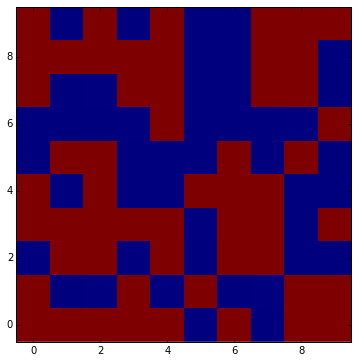

In [8]:
NMC = 100
ny=10
nx=10

def initial_state(nx,ny):
   
    # Uniform random spins between 0 and 1  
    r = numpy.random.random_integers(0,1,(nx,ny))
    
    #Where r=0, we assign a negative spin
    r[r==0] =-1

    return r

r=initial_state(nx,ny)
print(r)

pyplot.figure(figsize=(6,6))
pyplot.imshow(r,interpolation="none",origin='lower')

Nous voyons ici que nous avons bien généré une grille d'états stochastique

In [10]:
def energy_at_site(r,alpha,sigma,ix,iy):

    energy=-alpha*sigma*(r[(ix-1)%nx,iy]+r[(ix+1)%nx,iy]+r[ix,(iy-1)%ny]+r[ix,(iy+1)%ny])

    return energy

print(energy_at_site(r,alpha,1,5,5))

-0.0


In [11]:
alpha = 0.1
def metropolis_at_site(r,alpha,ix,iy):

    sigma=r[ix,iy]
    energy_before_flip = energy_at_site(r,alpha,sigma,ix,iy)
    sigma = -sigma
    energy_if_site_flipped = energy_at_site(r,alpha,sigma,ix,iy)
    
    #Flip the site with Metropolis probability
    # Condition is always satisifed if dE < 0
    if (numpy.random.random_sample()<numpy.exp(-(energy_if_site_flipped \
                                               -energy_before_flip))):
         r[ix,iy]=-r[ix,iy] 
            
#Calcul du ratio

states = numpy.empty(NMC+1)
states[0]=r[5,5]

for n in range(0,NMC):
    metropolis_at_site(r,alpha,5,5)
    states[n]=r[5,5]

ups = numpy.extract(states==1, states).size
downs = NMC - ups


print("")
print("Ratio d'états pointant vers le haut ou vers le bas :")
print("")
print(ups/downs)



Ratio d'états pointant vers le haut ou vers le bas :

1.0


On obtient une valeur approché du ratio d'états pointant vers le haut ou vers le bas pour une grille de même taille et un même nombre d'états. On en conclut donc que ce n'est pas une coincidence !

Par contre, la valeur fluctue en fonction de la configuration des états:
$$ {(\uparrow,\uparrow);(\uparrow,\downarrow);(\downarrow,\uparrow);(\downarrow,\downarrow)}$$



## Back to the Ising Model

















Our objective in this section is to show that the ferromagnetic material is indeed subject to a phase transition at a given coupling constant $\alpha$ by using the Metropolis algorithm to generate a sequence of lattices with the right probabilities.

We first initialize the lattice with all spins pointing upwards (i.e. we assume that the material has been completely magnetized).

In [12]:
nx = 100
ny = 100

sp = numpy.ones([nx,ny])









We now need a routine to create a sequence of states by trying to flip the spins at random sites if the Metropolis condition is satisfied. Note that instead of keeping all the states, we attempt $nx*ny$ flips between the retained ones so that the system has a chance to change significantly.

In [13]:
def ising_model_metropolis(sp, NMC, nx, ny, alpha):
    """ Creates a sequence of states for the Ising model using
    the Metropolis algorithm
   
    Parameters:
    ----------
    sp   : initial lattice state
    nx   : int
        Discretization points in x
    ny   : int
        Discretization points in y
    NMC  : int
        Number of states to create
    alpha  : real
        coupling constant J/(kb*T)
    Returns:
    -------
    states: sequence of states
    """
    states = numpy.empty([NMC+1,nx,ny])
    states[0] = sp.copy()
    
    for i in range(1,NMC+1):
        for j in range(0,nx*ny):
            ix=numpy.random.random_integers(0,nx-1)
            iy=numpy.random.random_integers(0,ny-1)
            metropolis_at_site(sp,alpha,ix,iy)
        states[i]=sp.copy()
    return states










OK, let's compare what happens for two different values of the coupling constant $\alpha$. In the examples below, we gather 100 states; this number is quite low as we want to keep modest simulation times.

In [14]:
NMC=100
alpha=0.2
states_0_2 = ising_model_metropolis(sp, NMC, nx, ny, alpha)

In [15]:
NMC=100
sp = numpy.ones([nx,ny])
alpha=0.7
states_0_7 = ising_model_metropolis(sp, NMC, nx, ny, alpha)


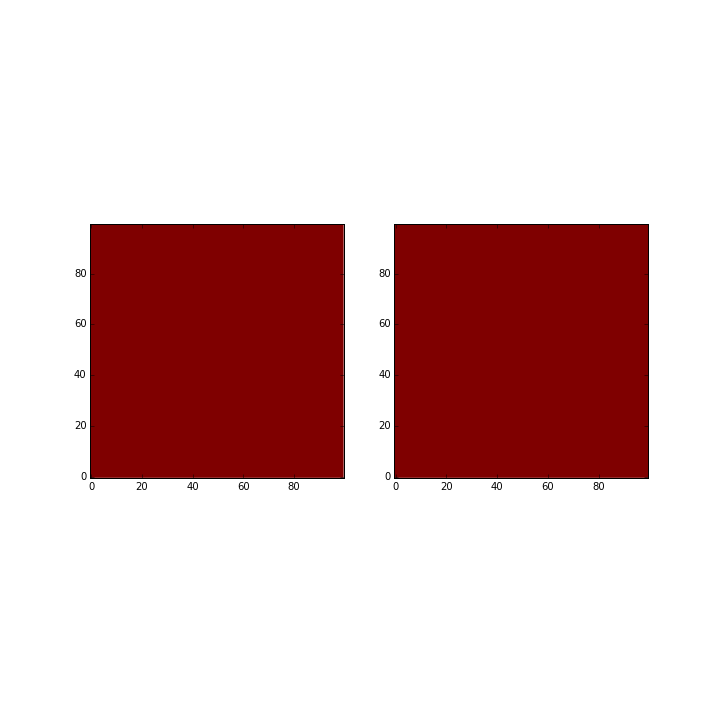
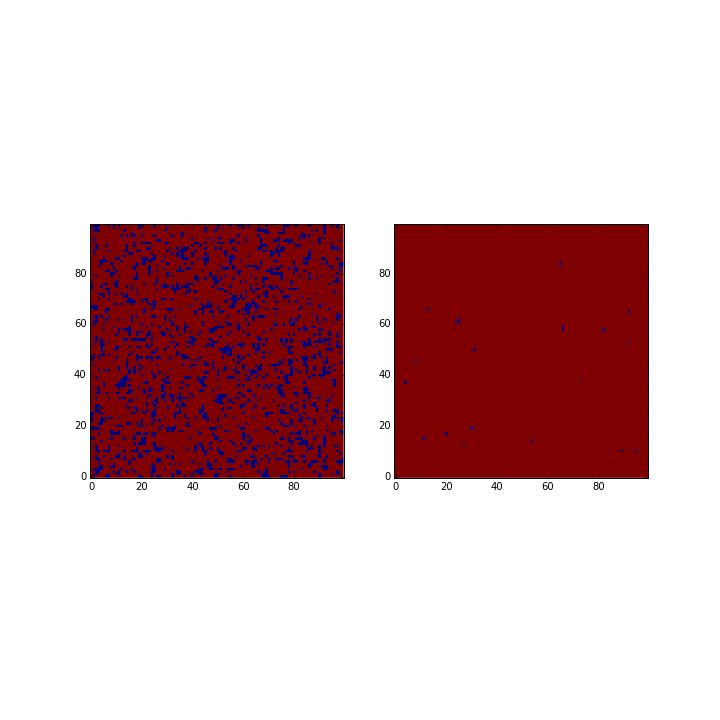
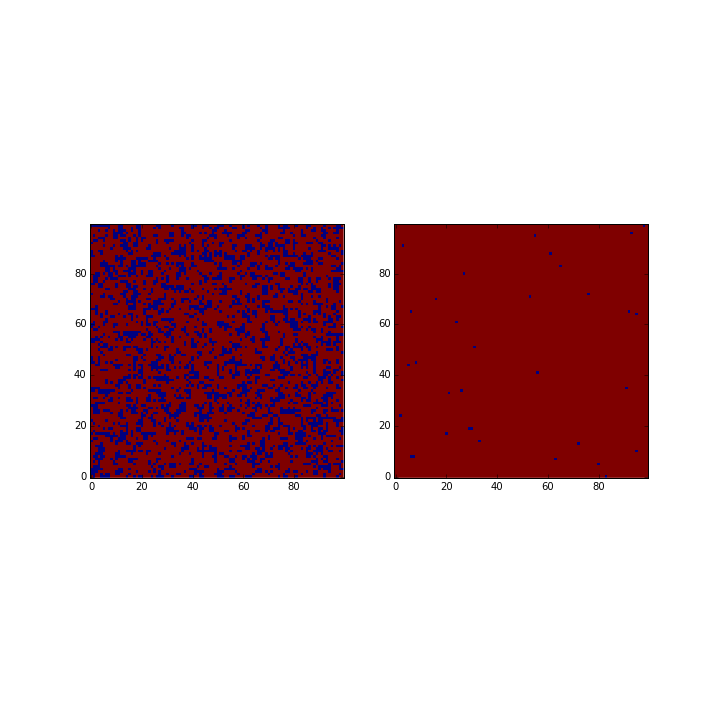
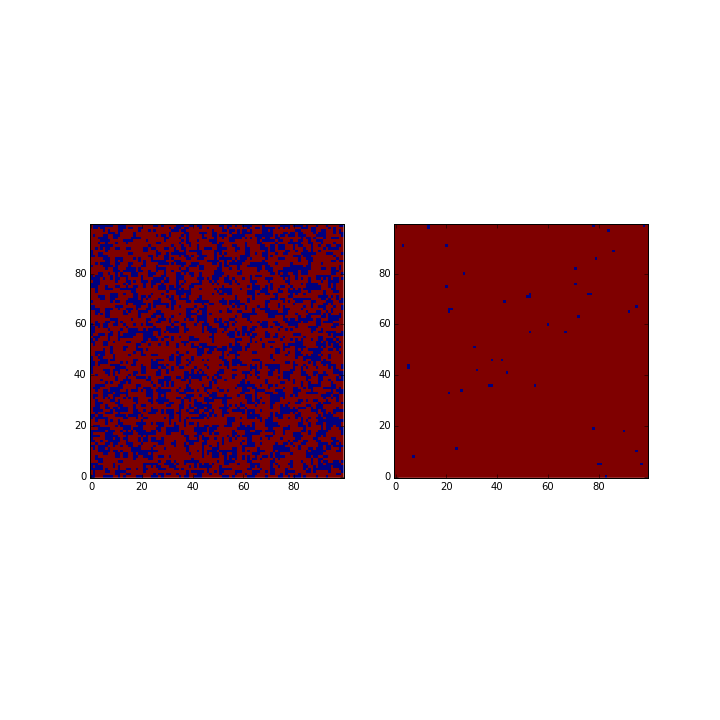
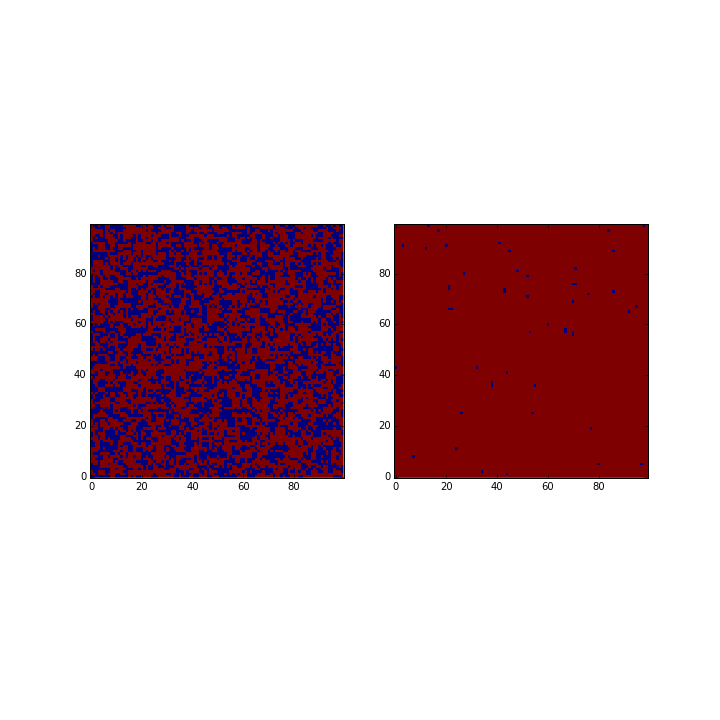
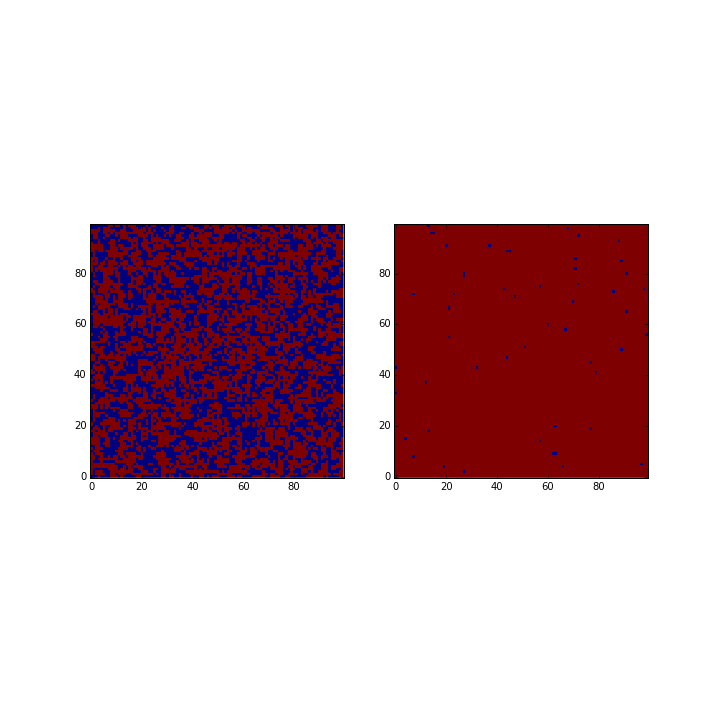
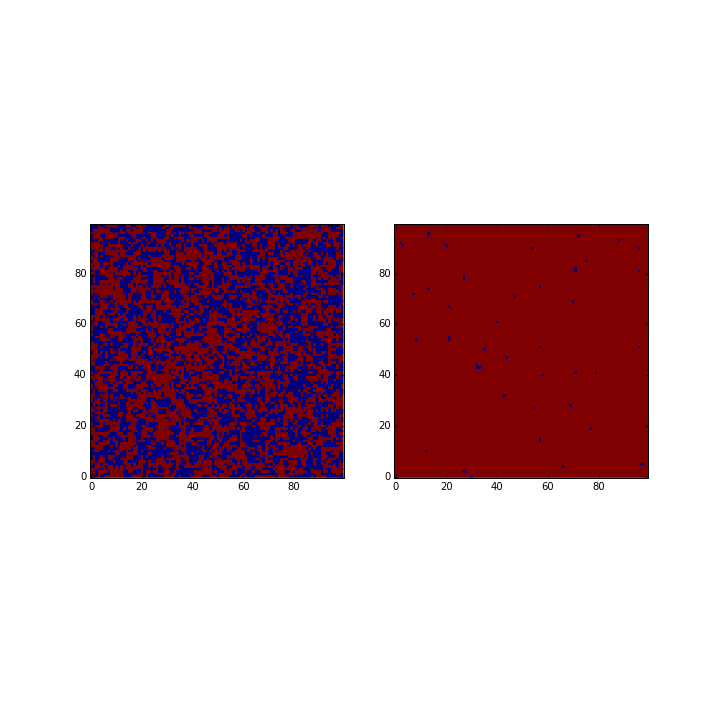
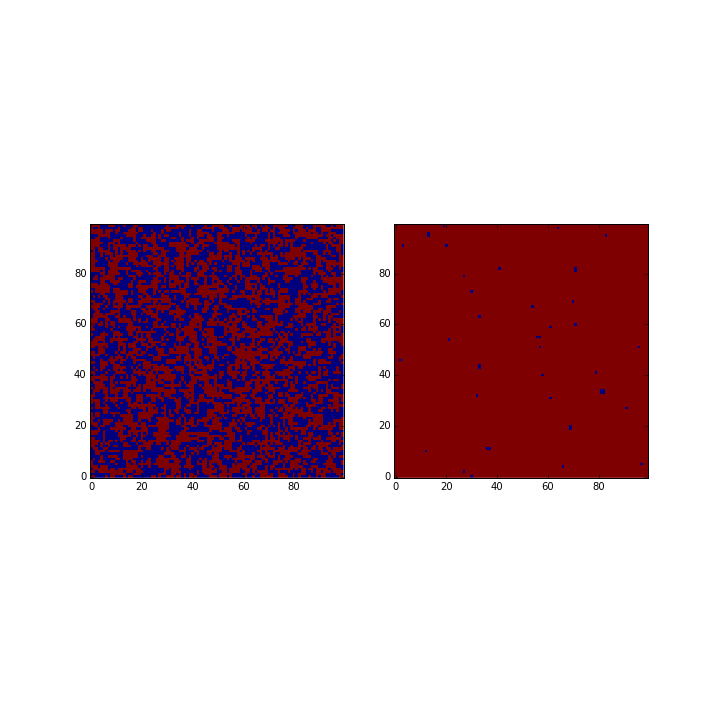
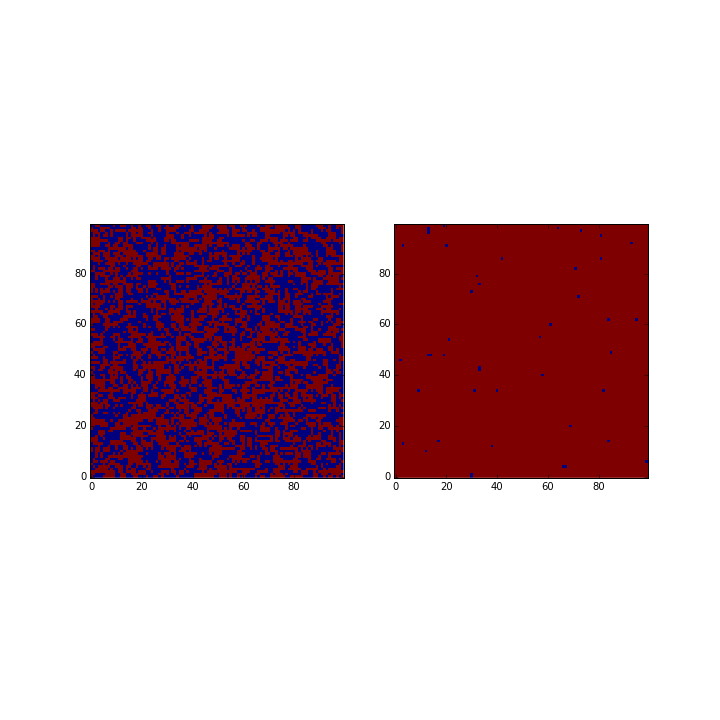
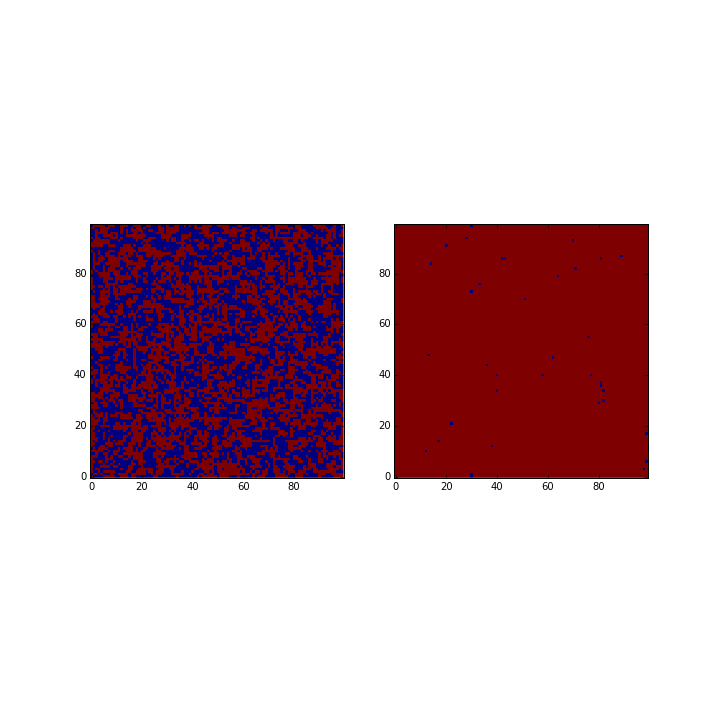
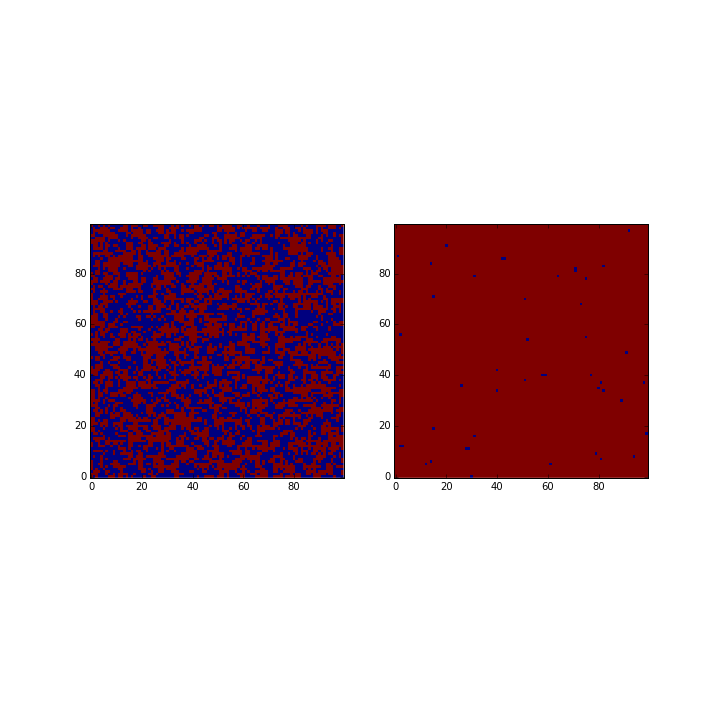
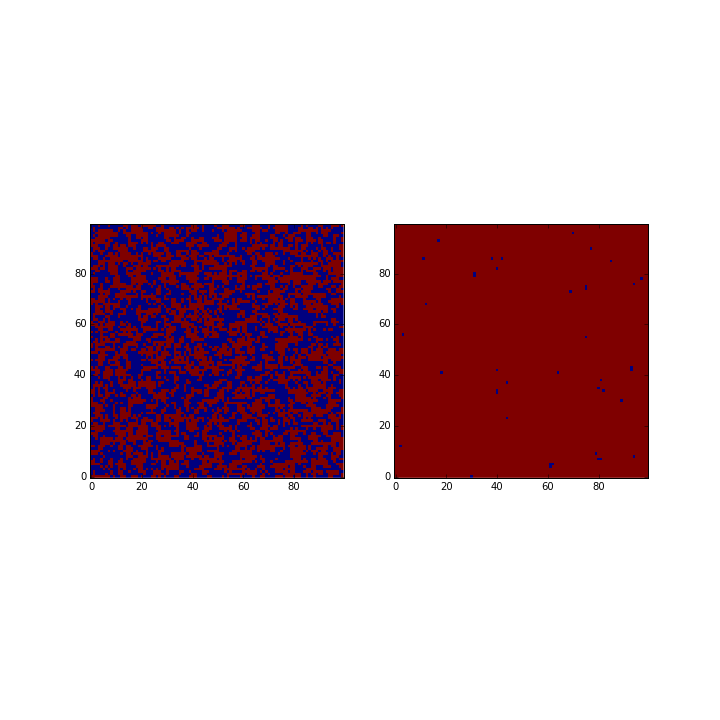
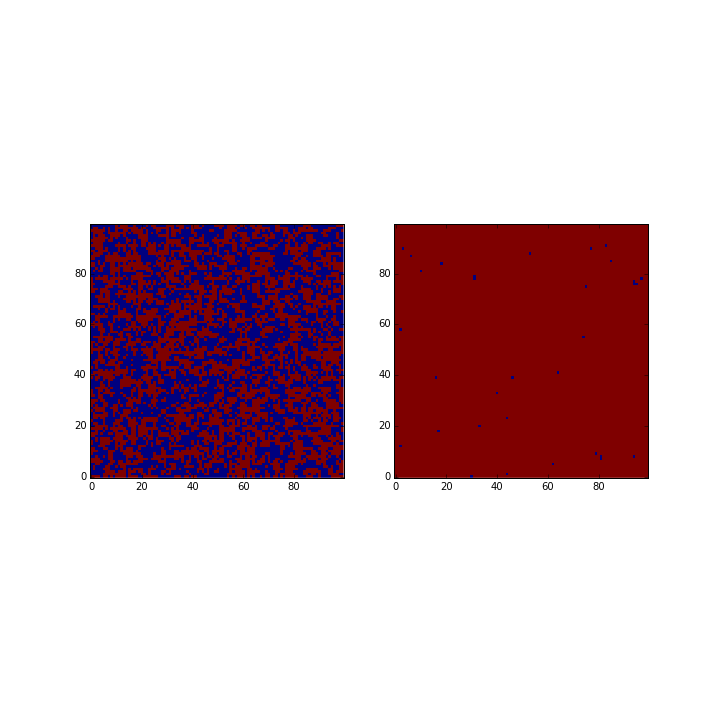
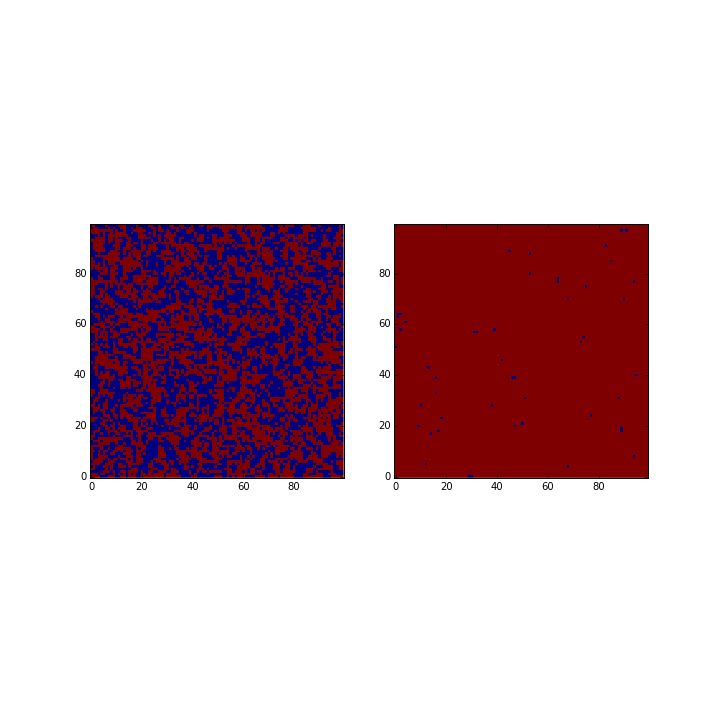
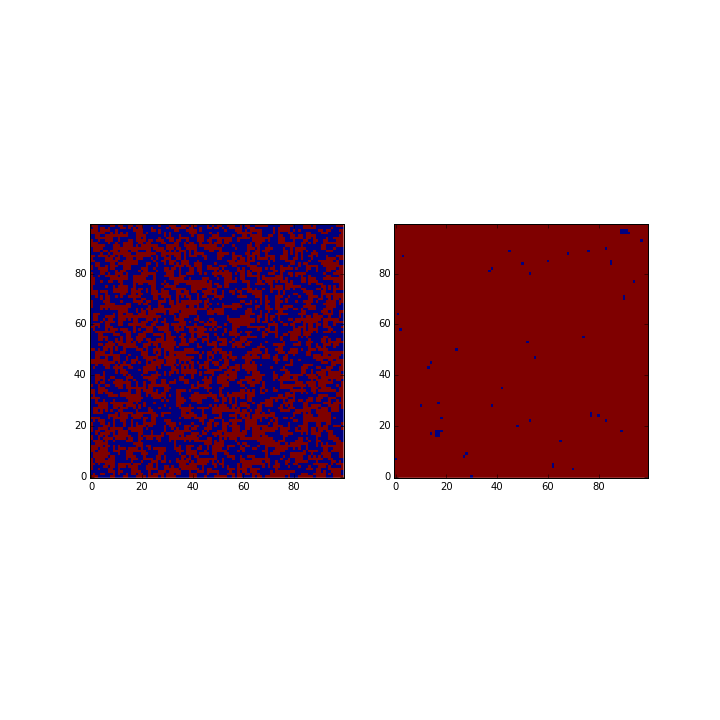
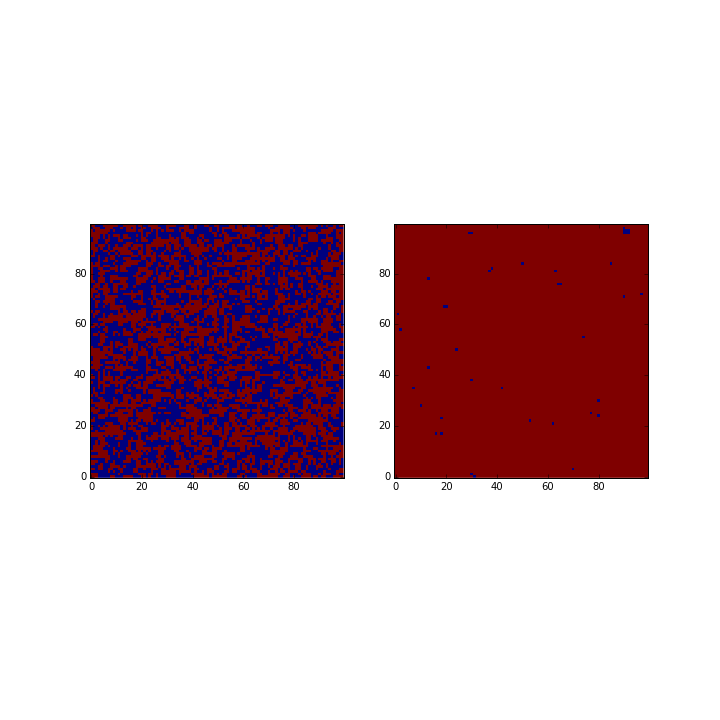
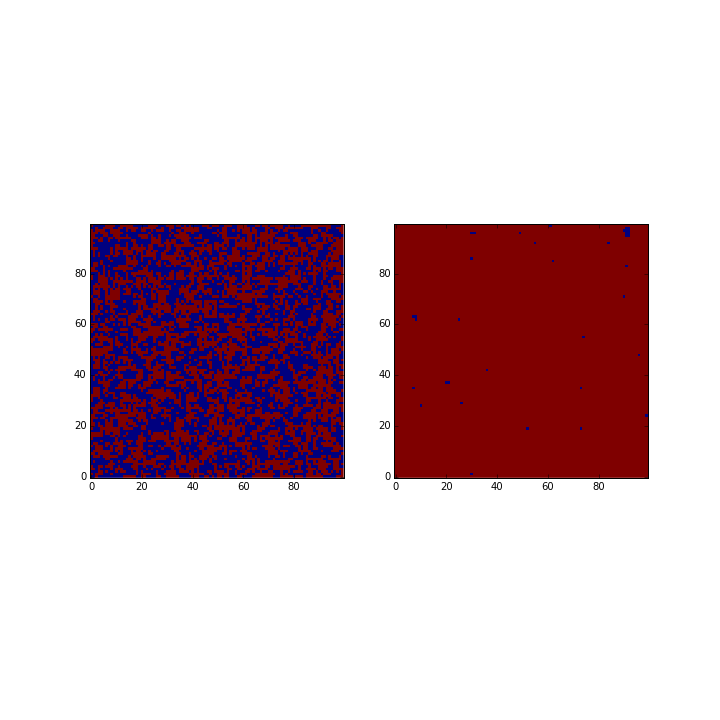
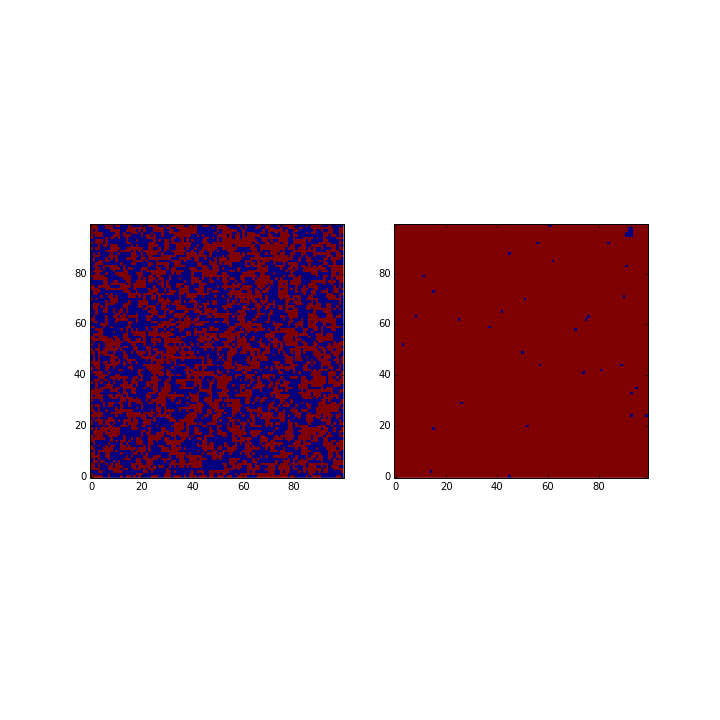
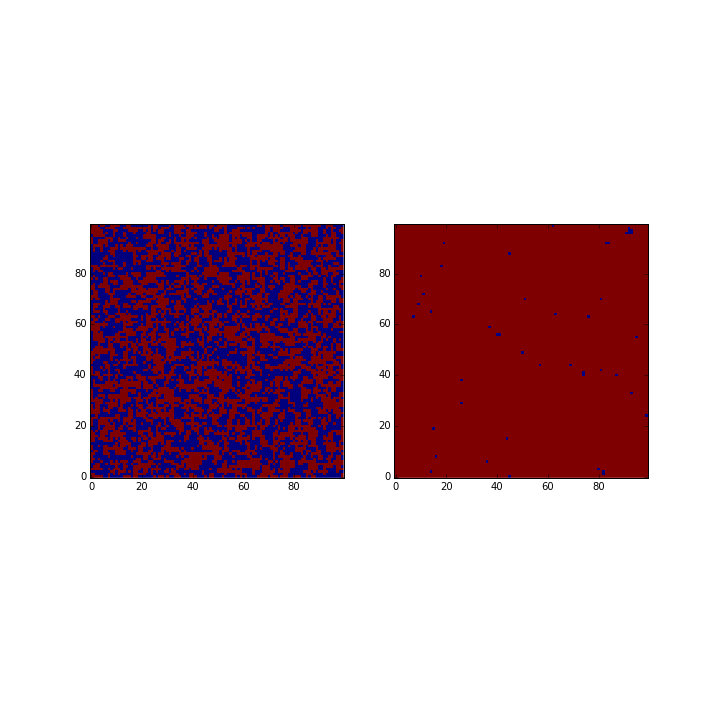
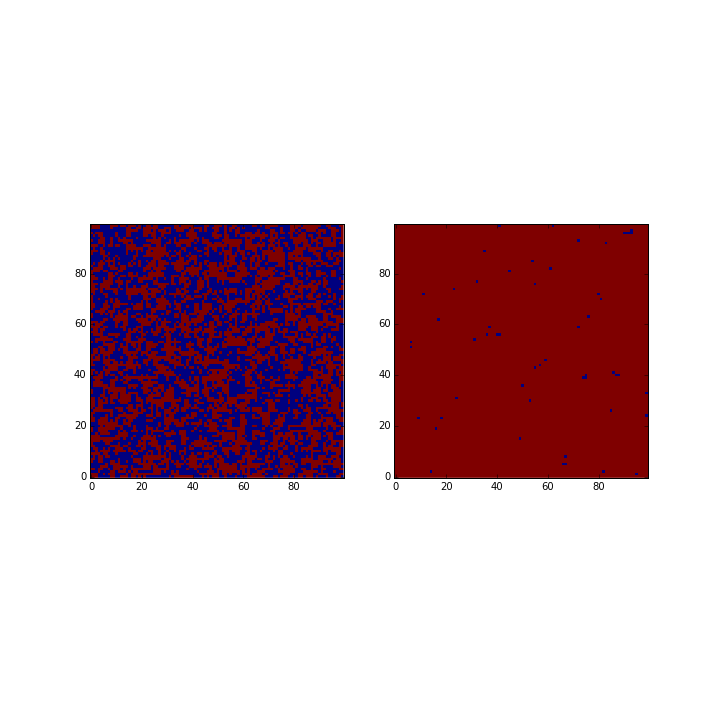
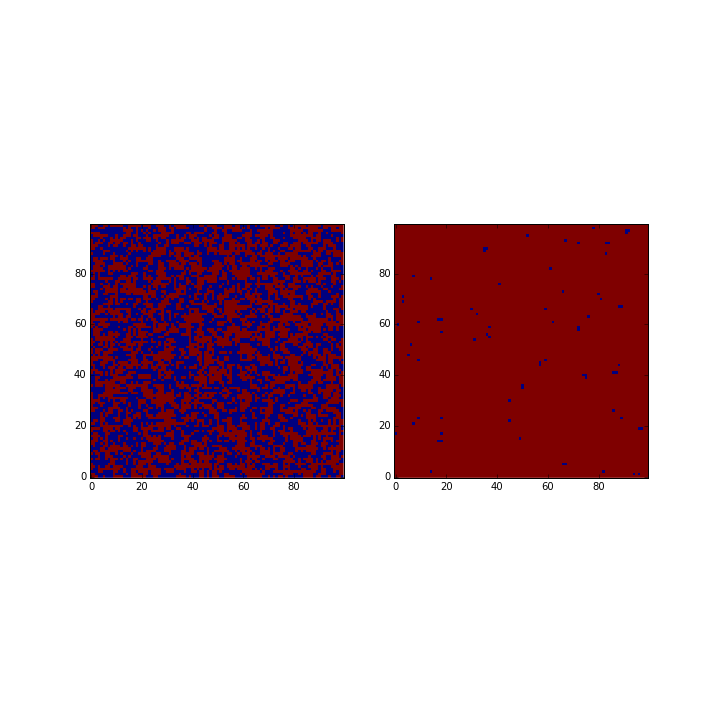
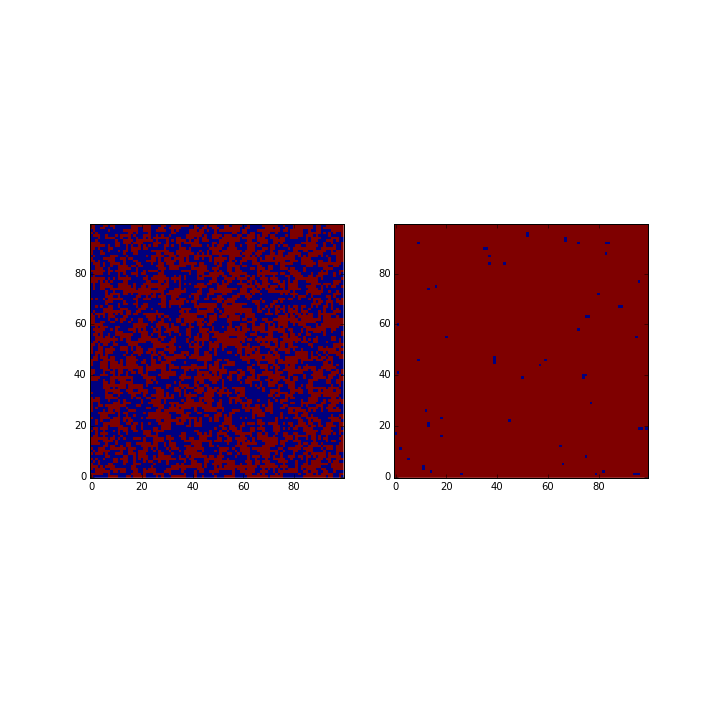
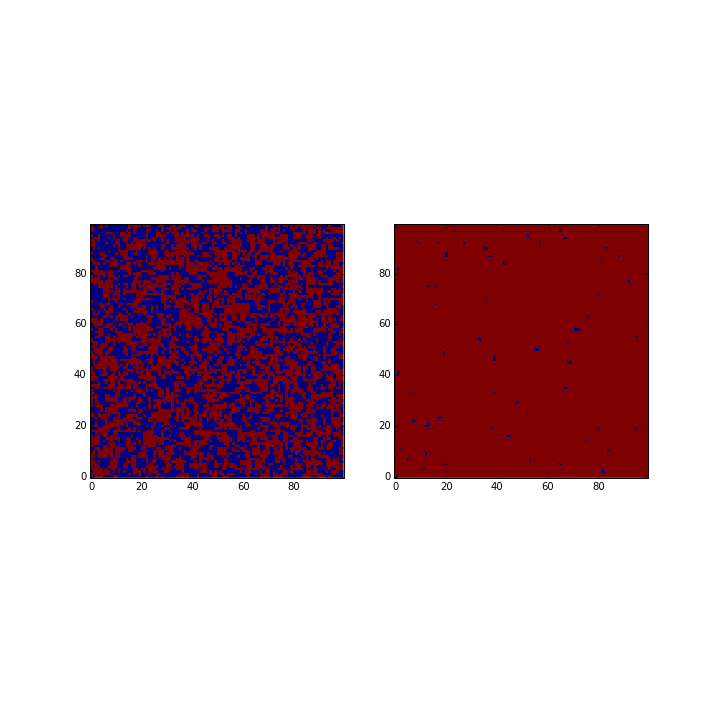
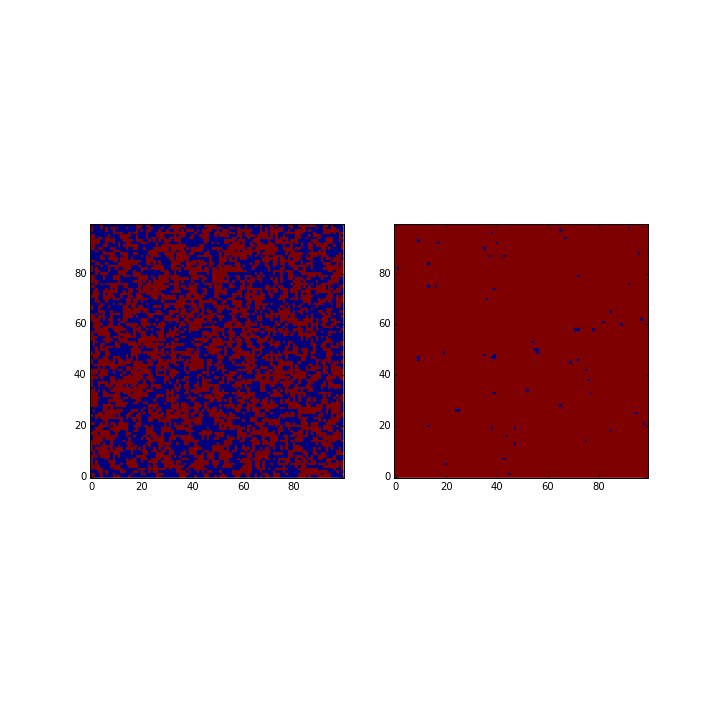
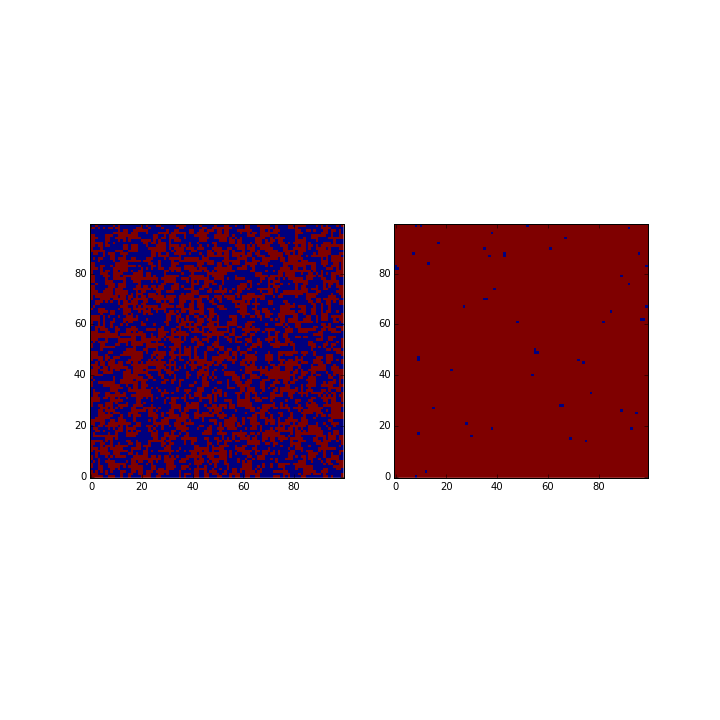
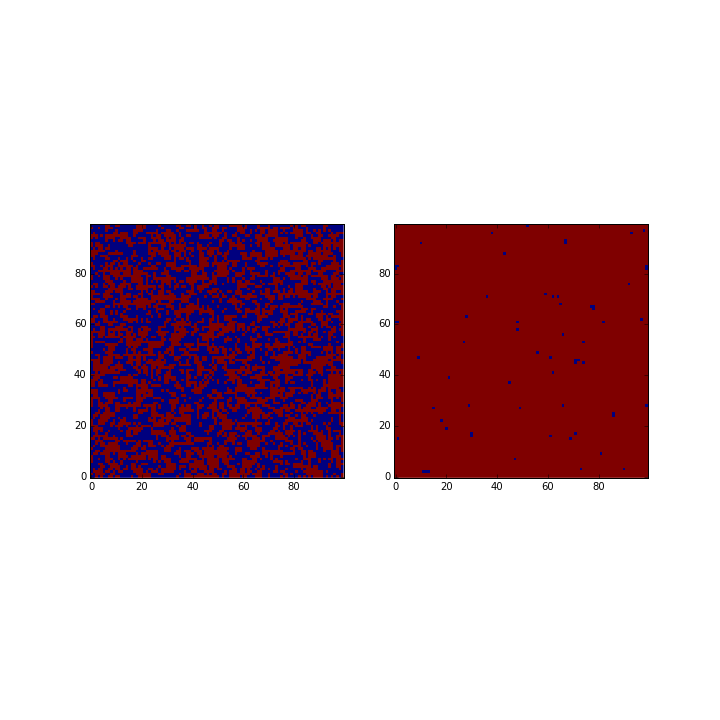
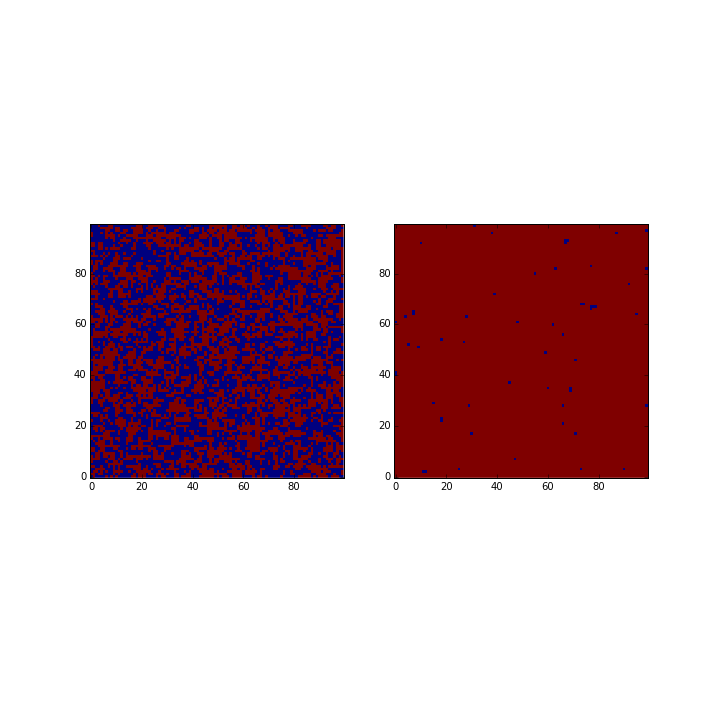
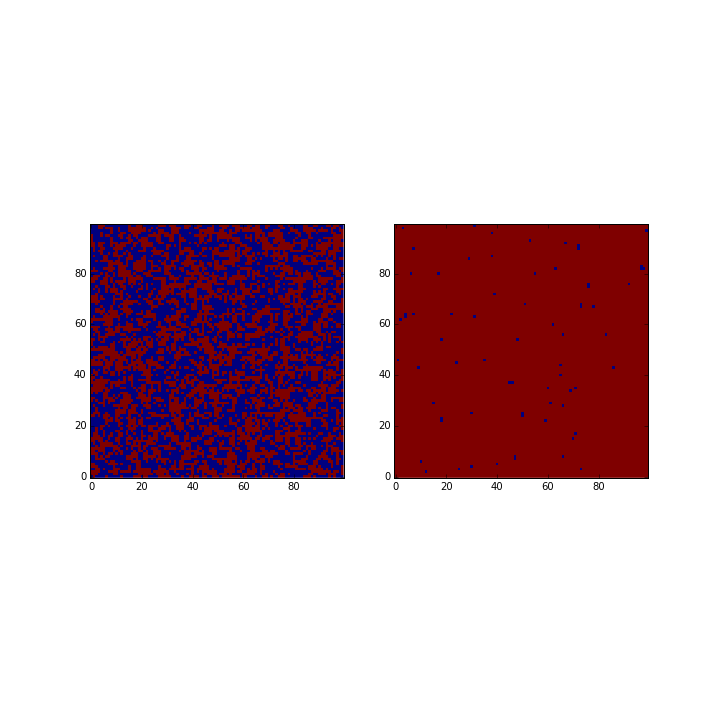
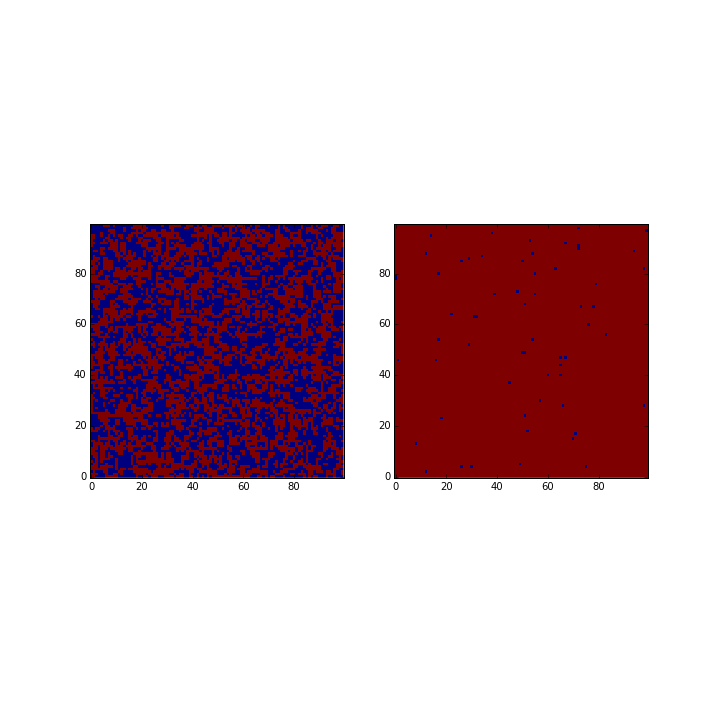
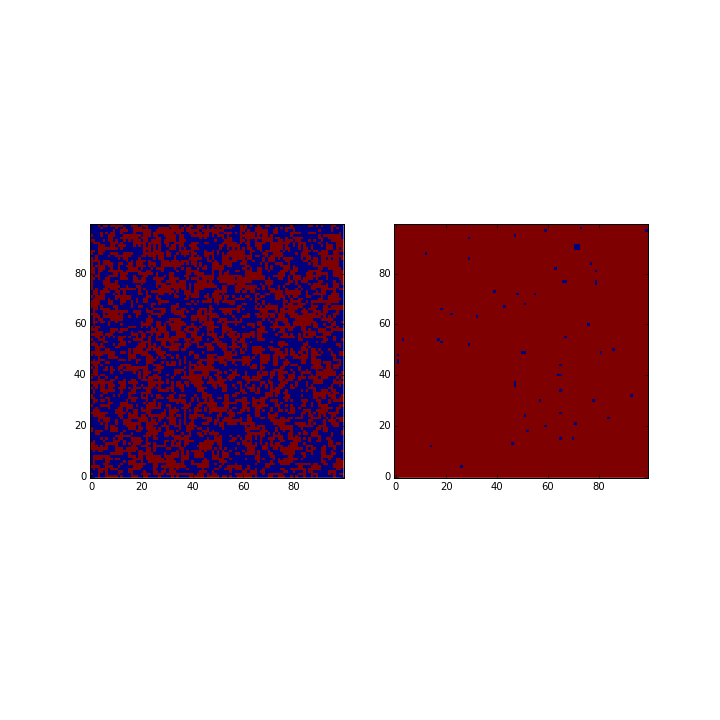
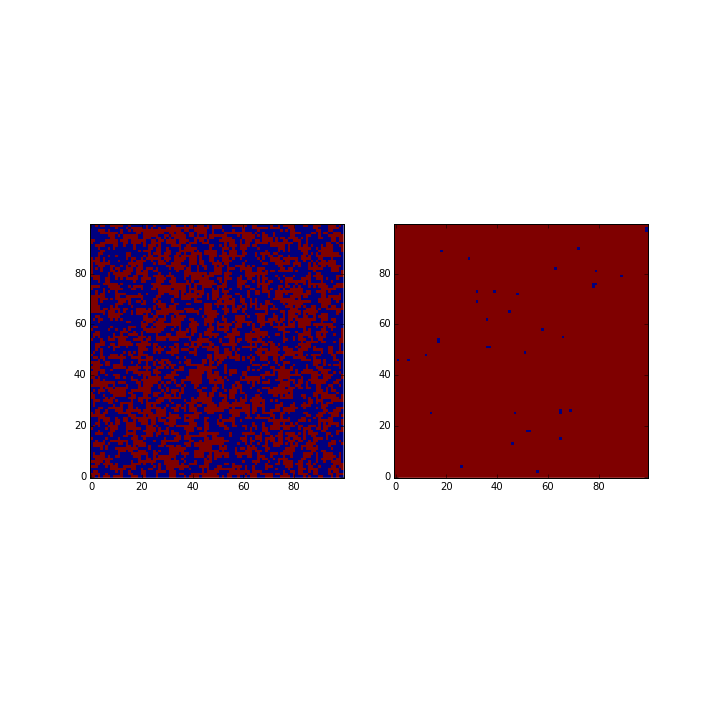
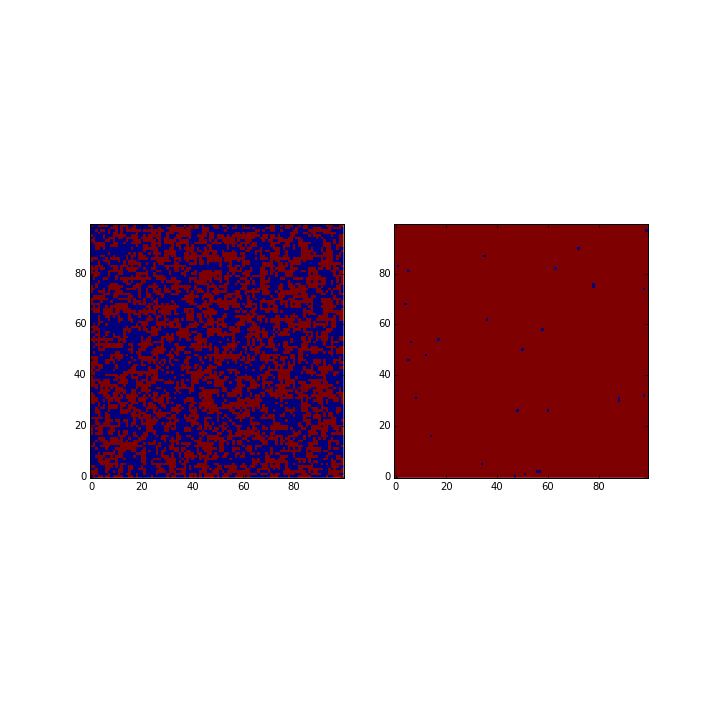
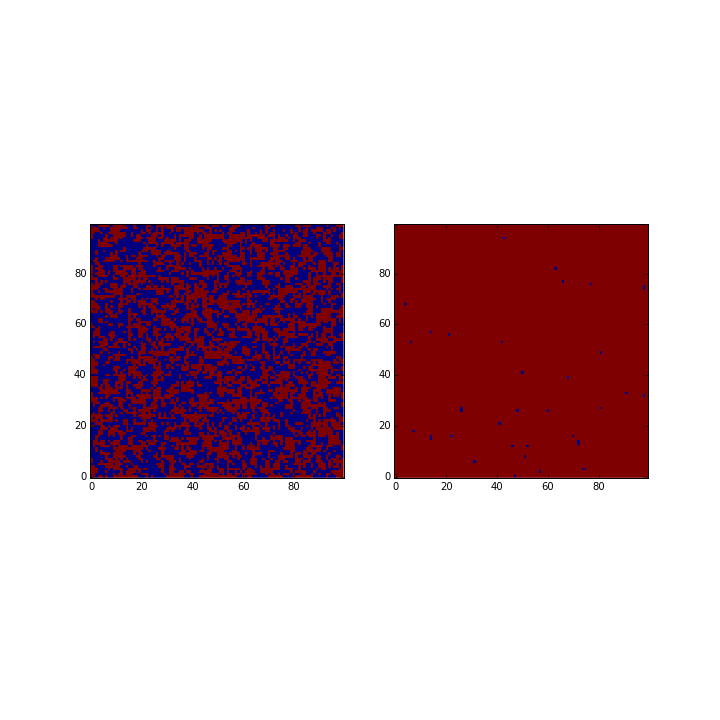
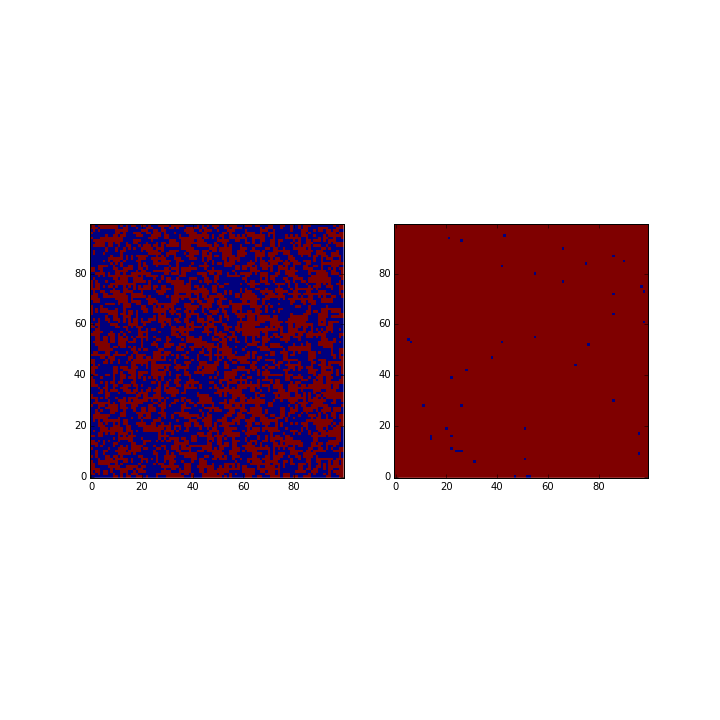
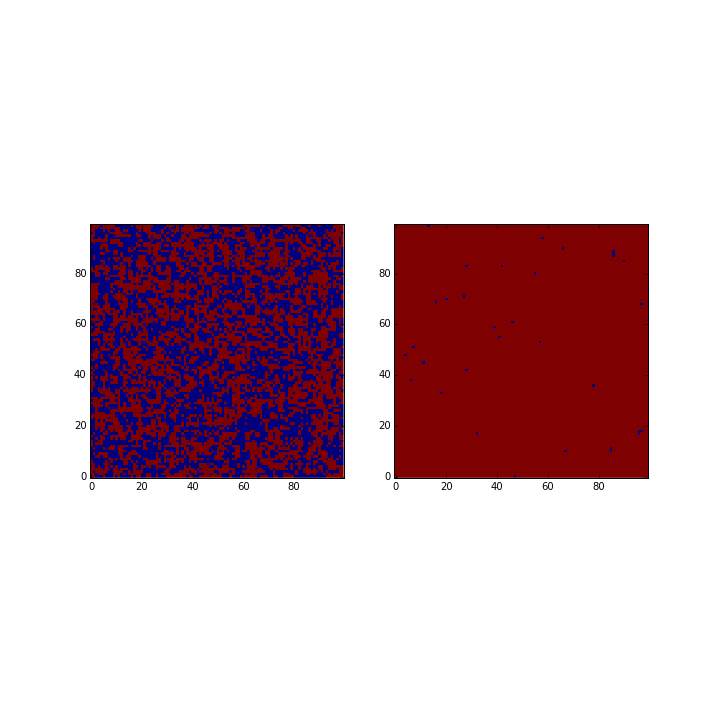
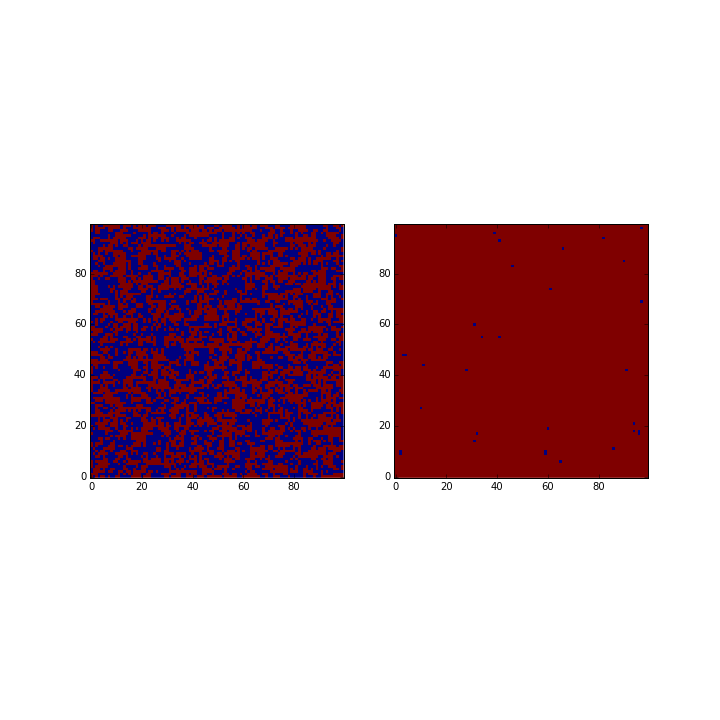
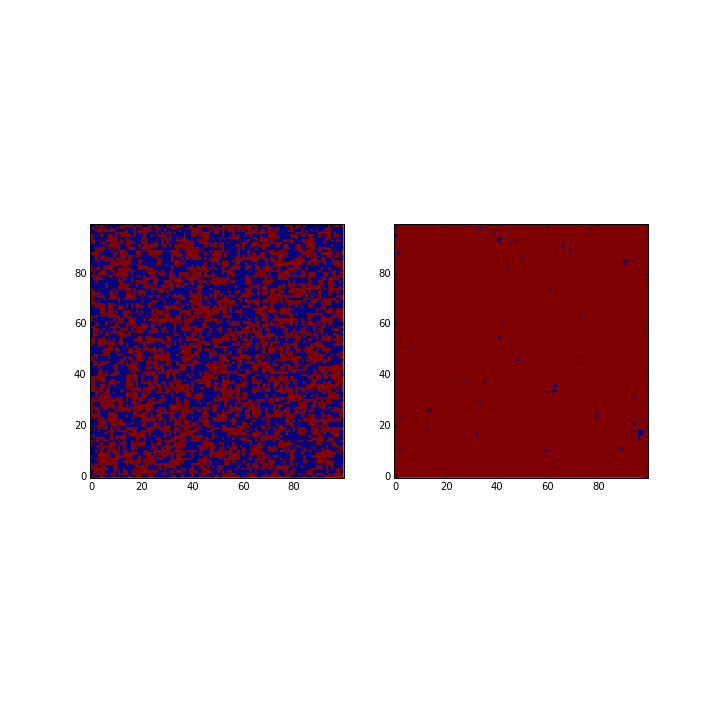
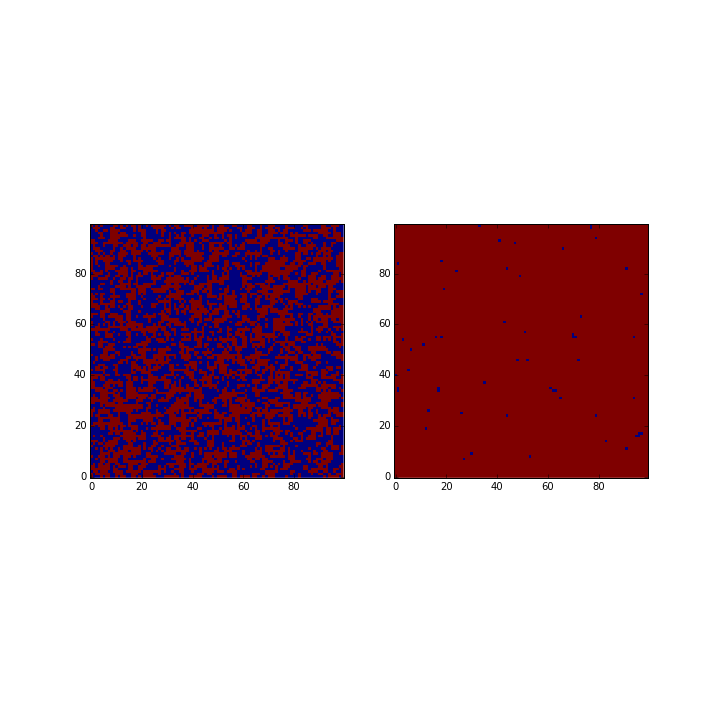
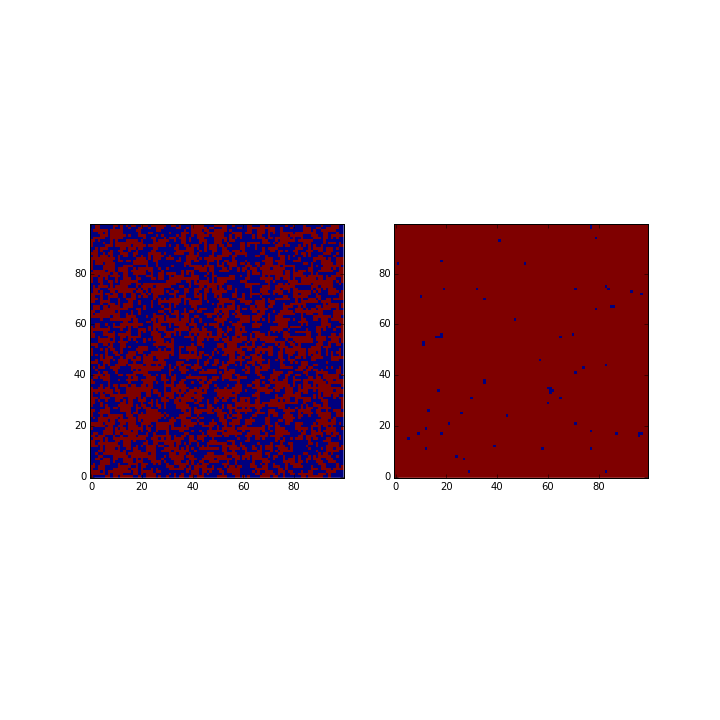
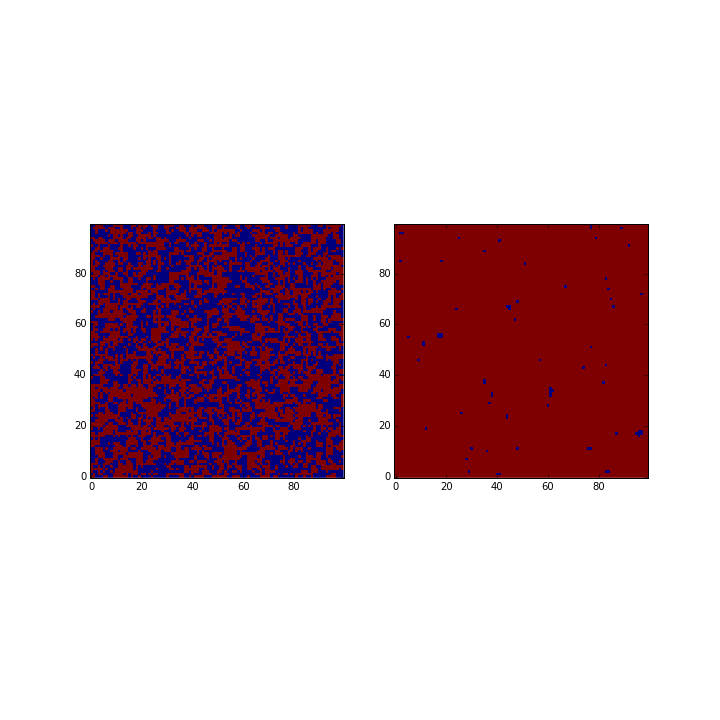
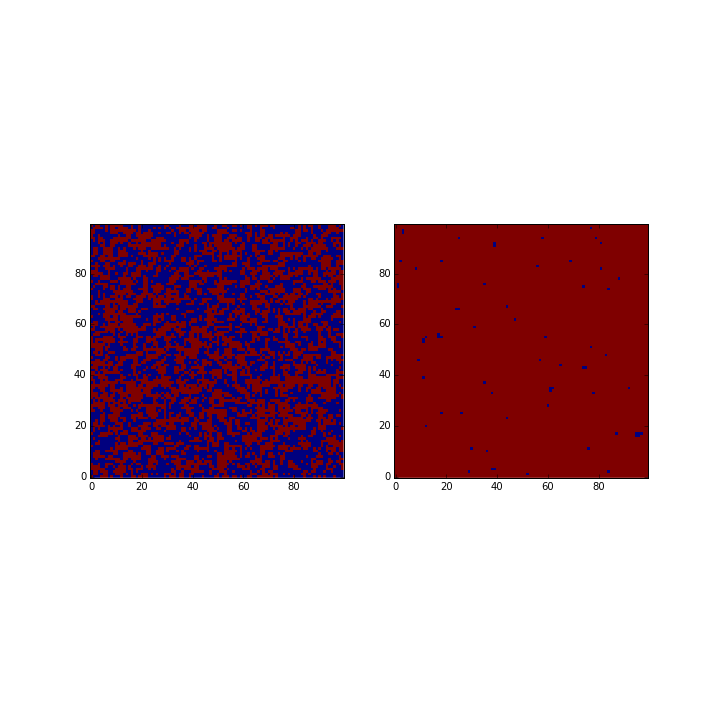
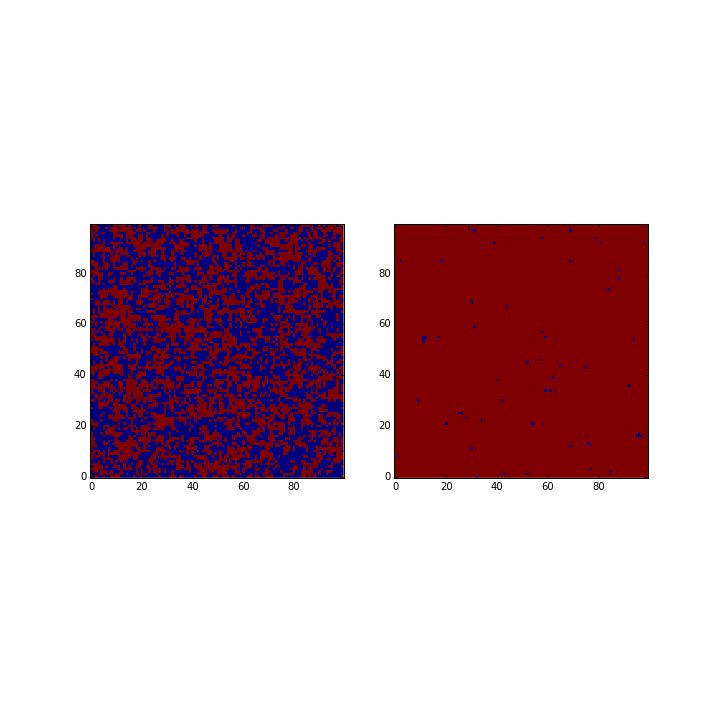
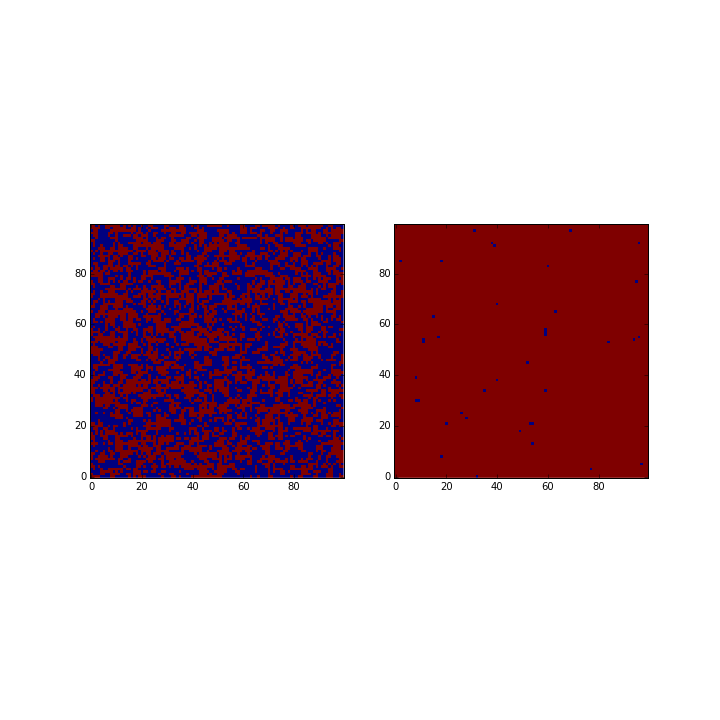
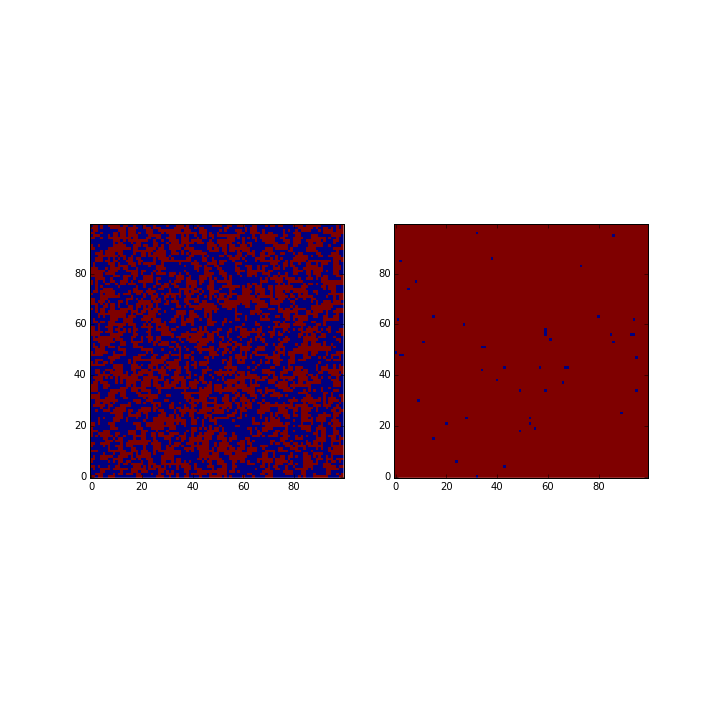
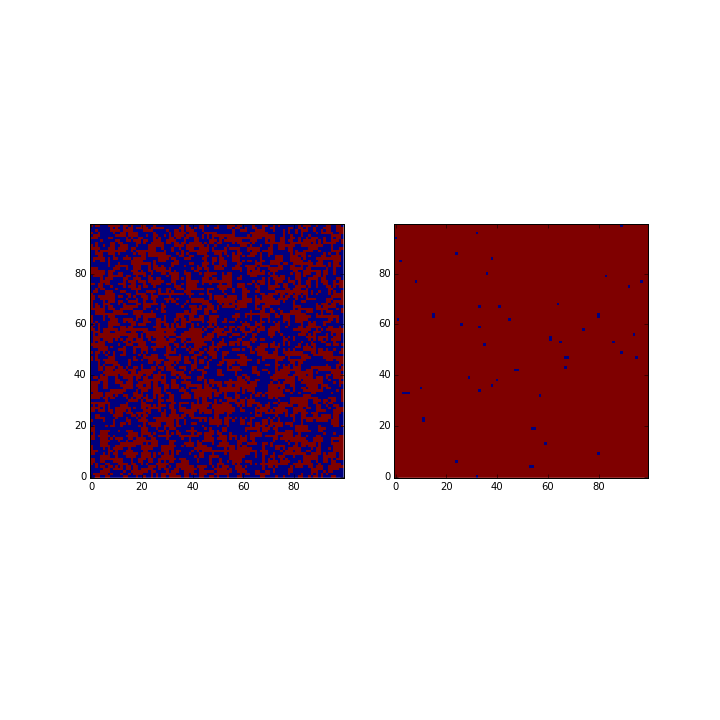
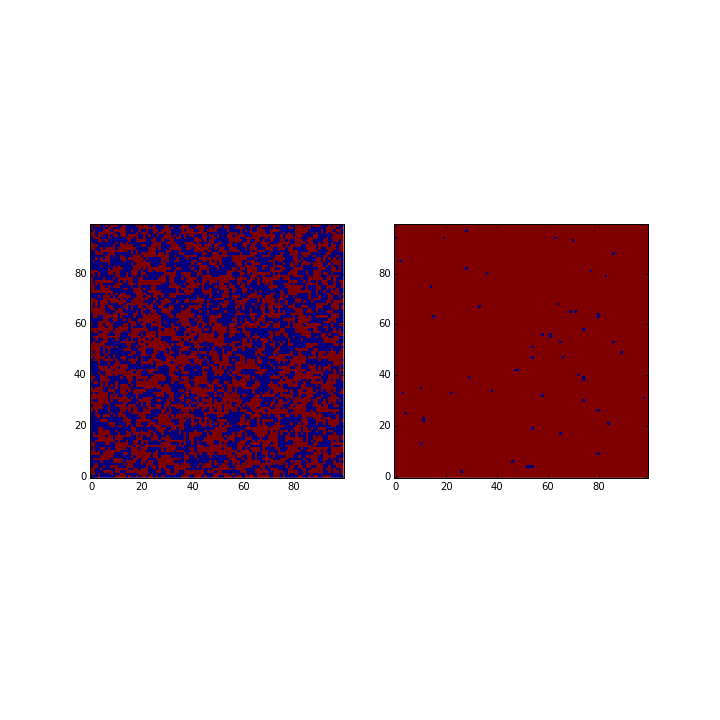
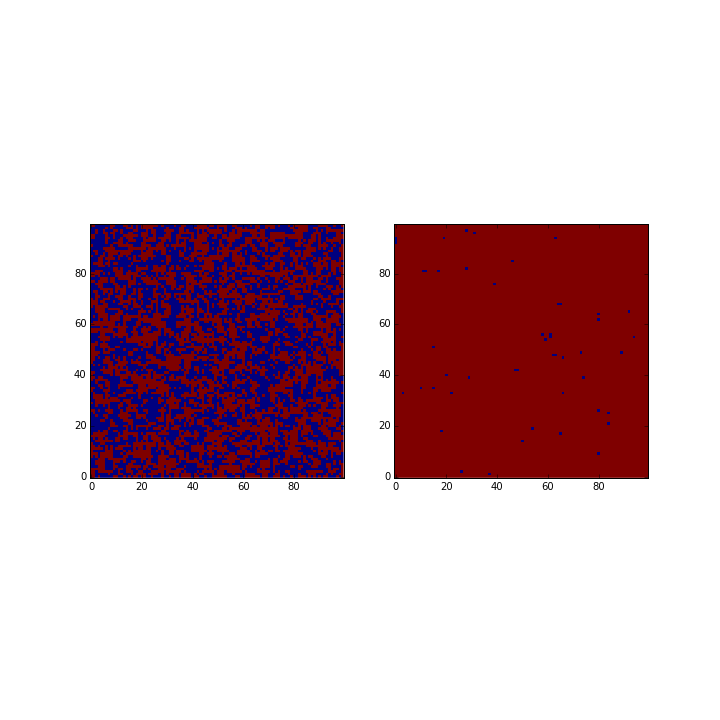
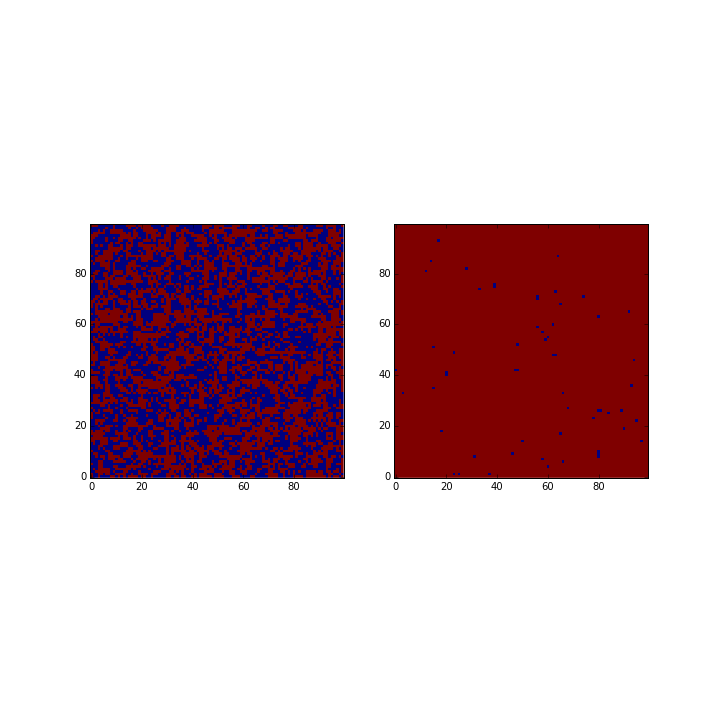
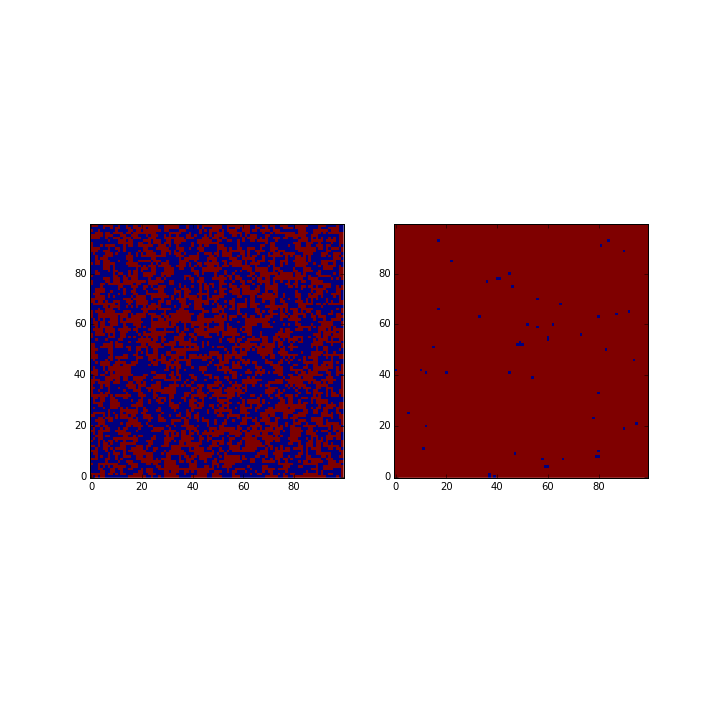
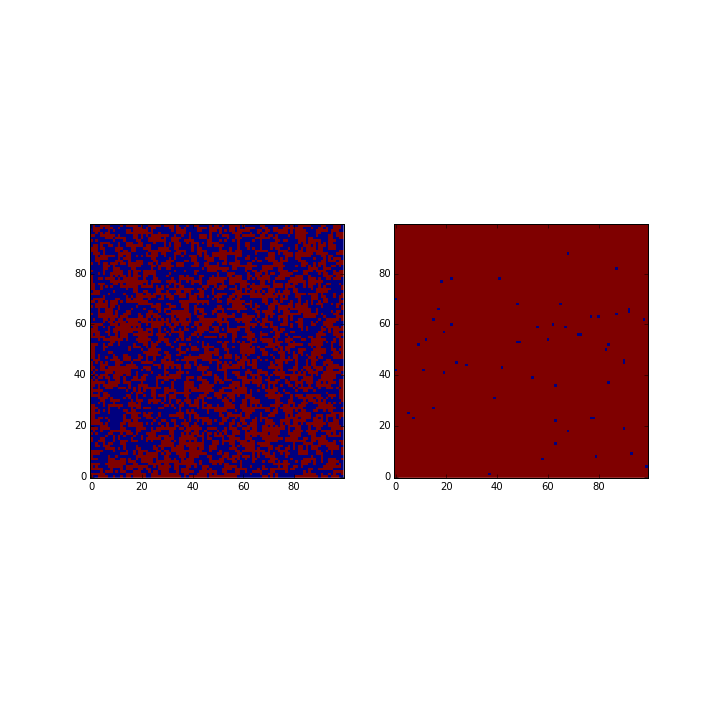
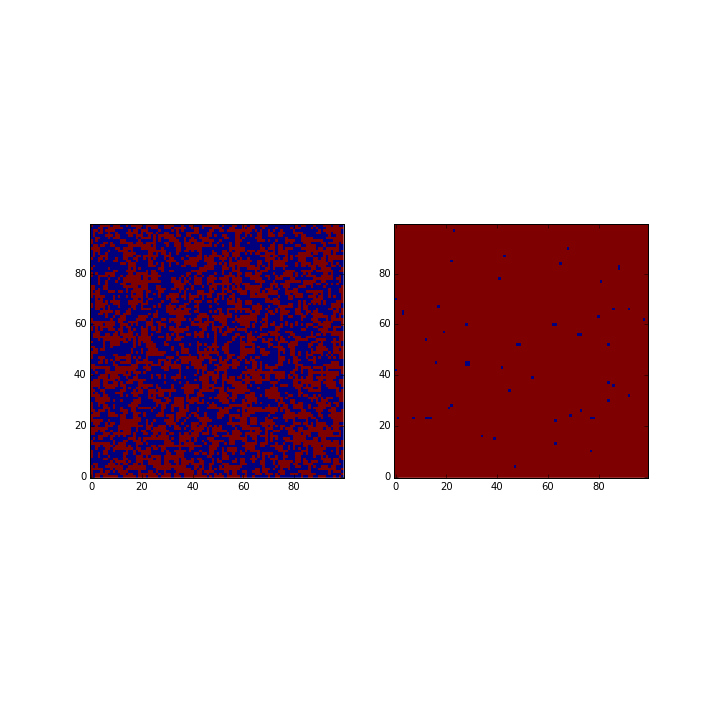
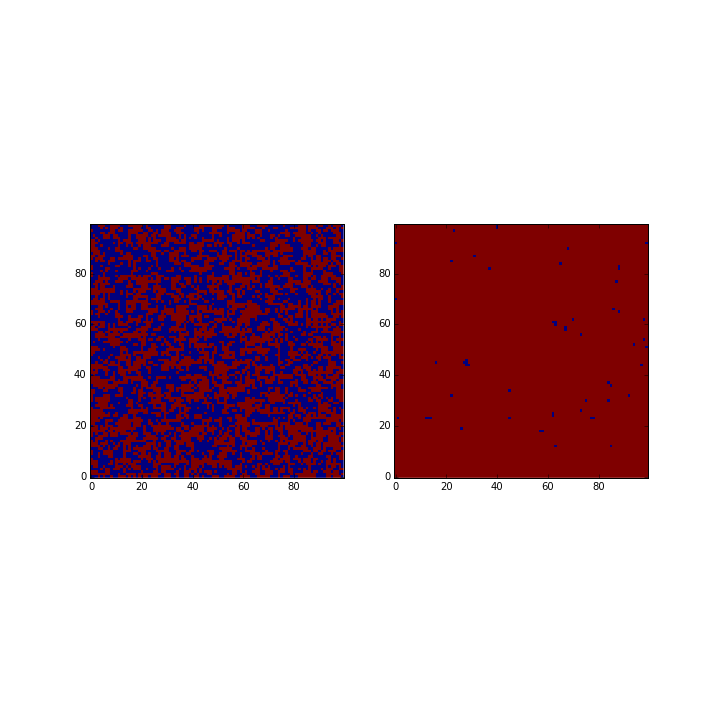
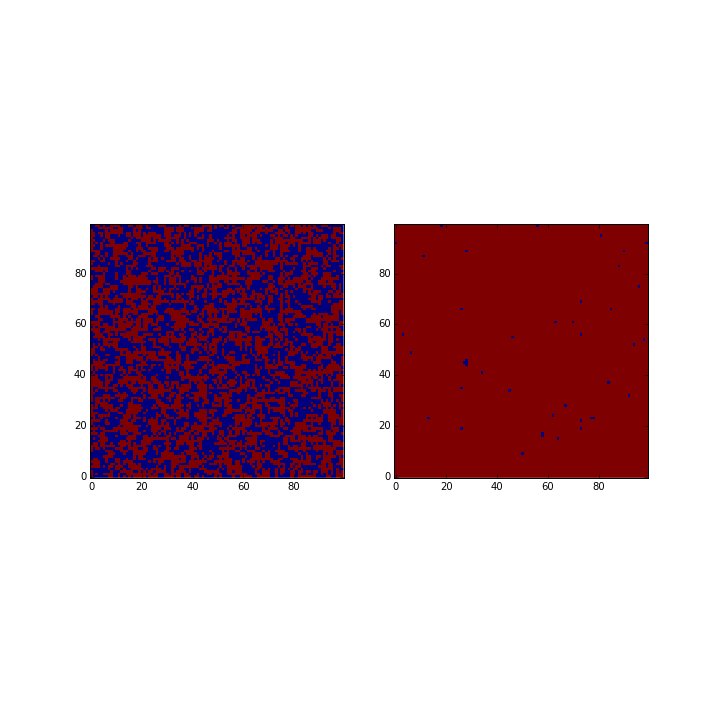
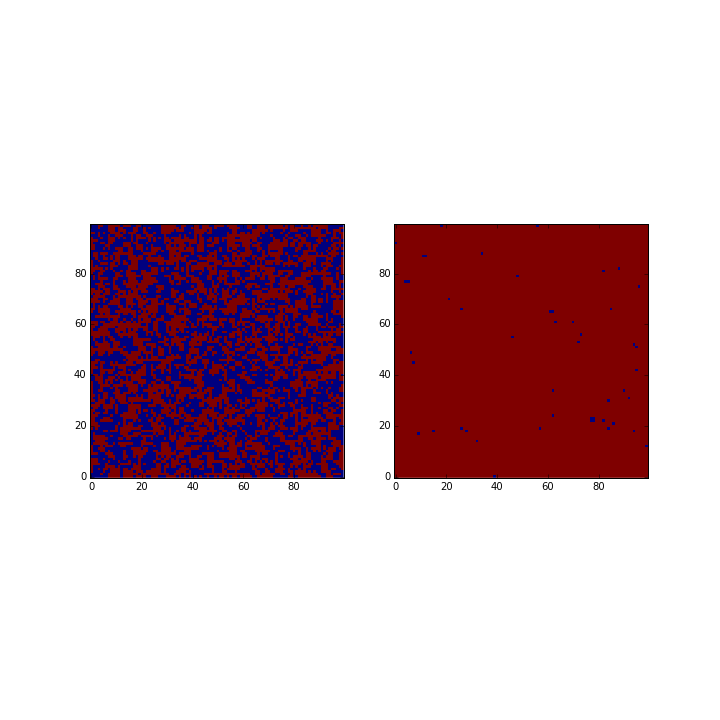
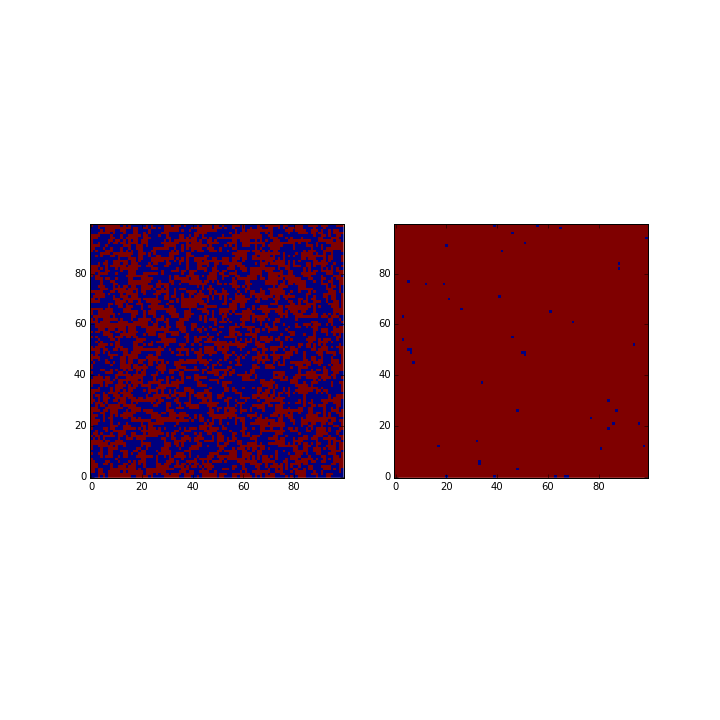
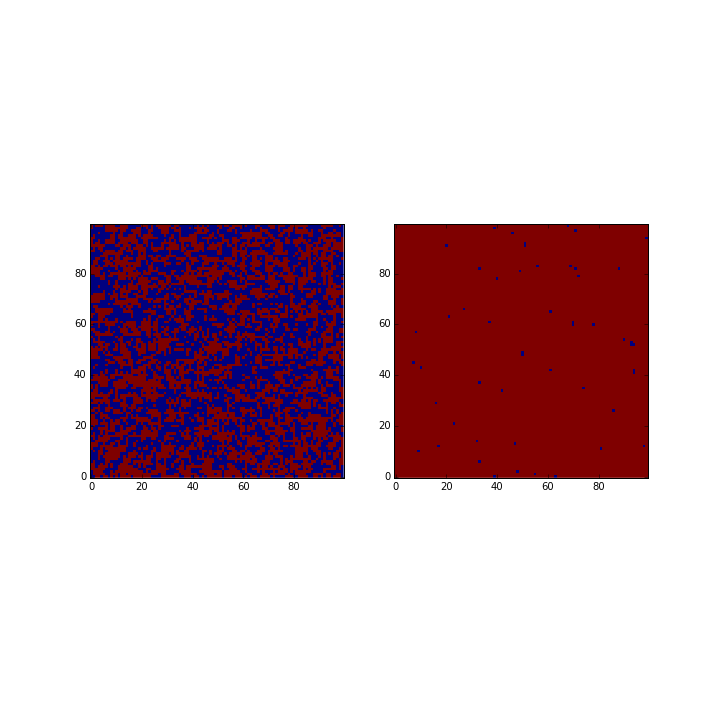
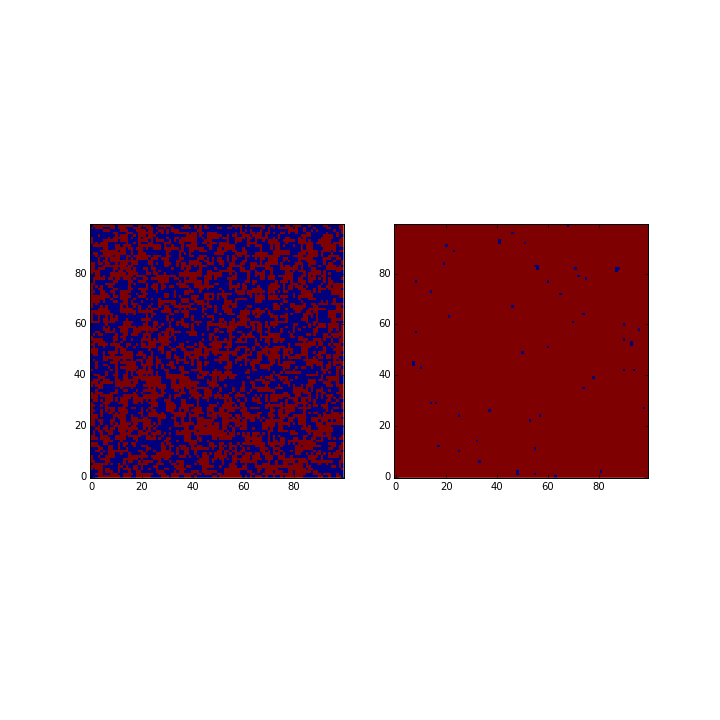
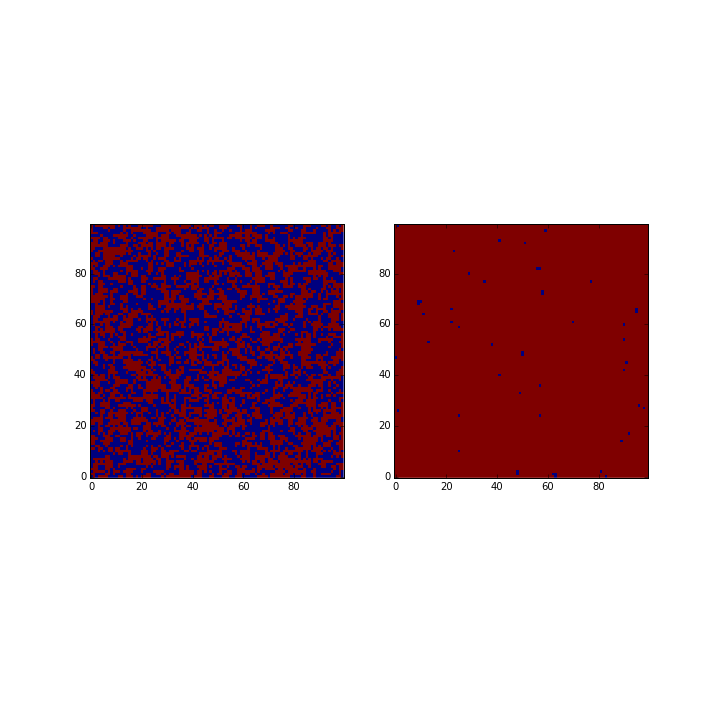
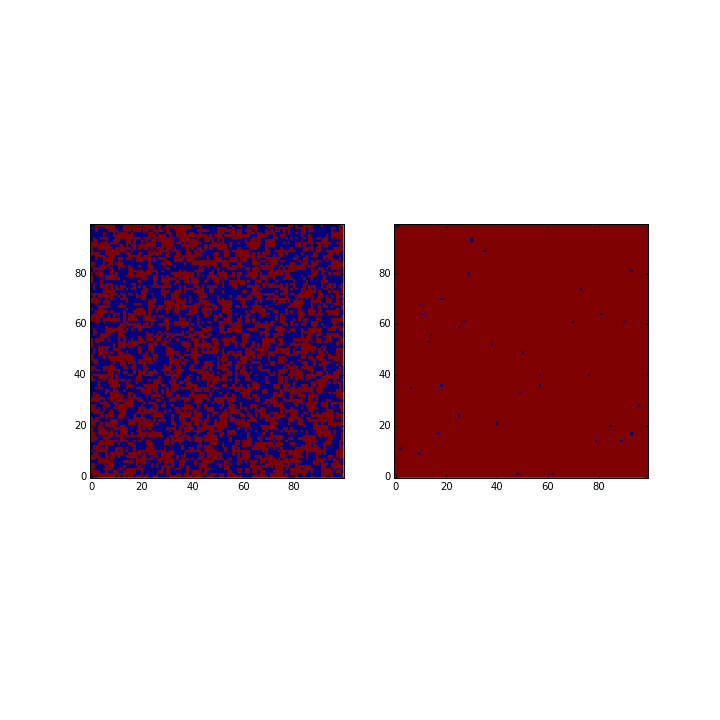
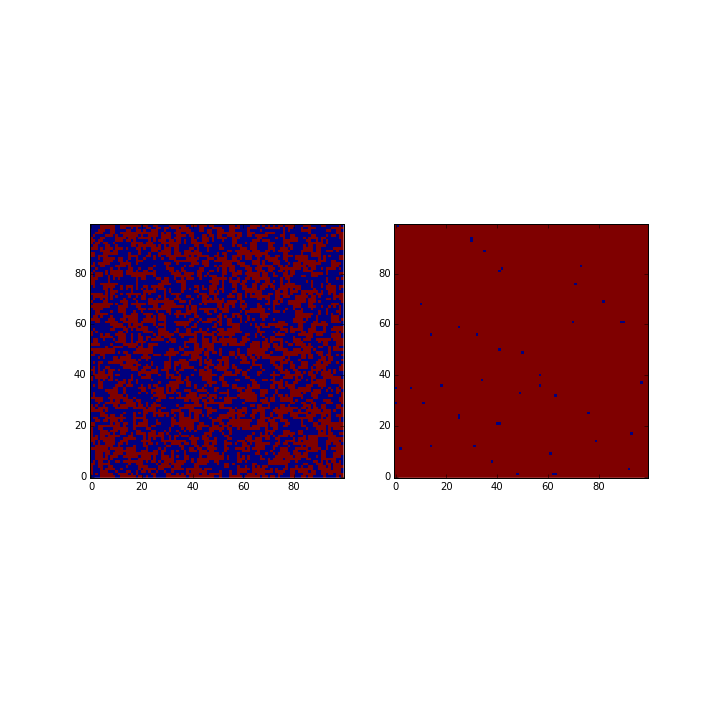
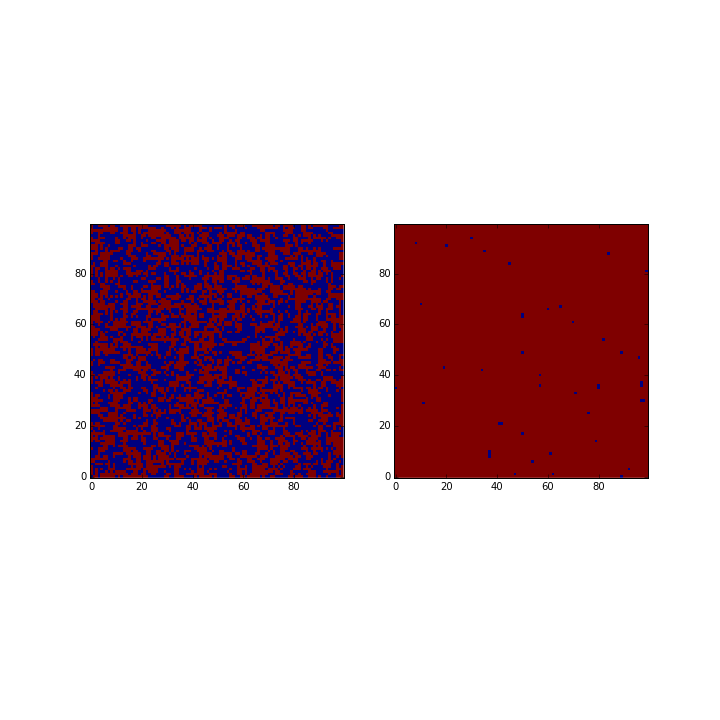
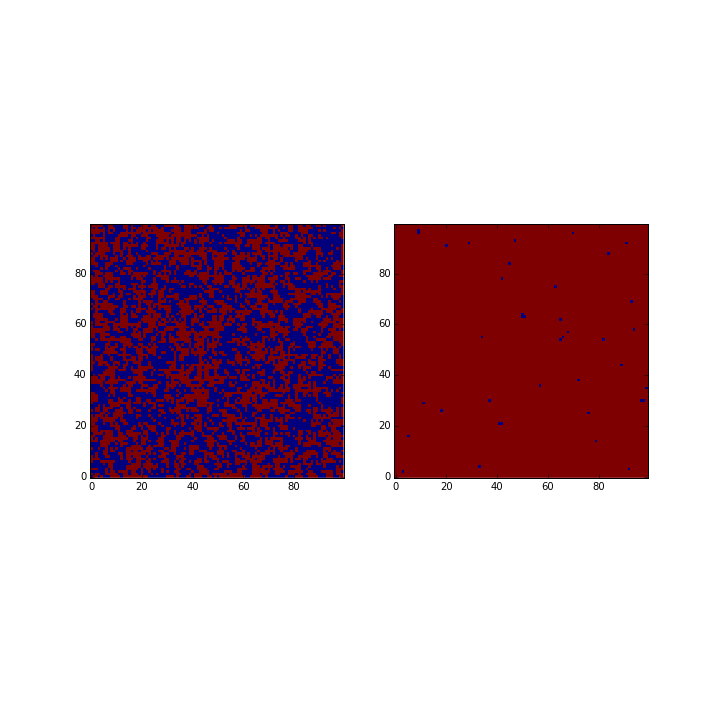
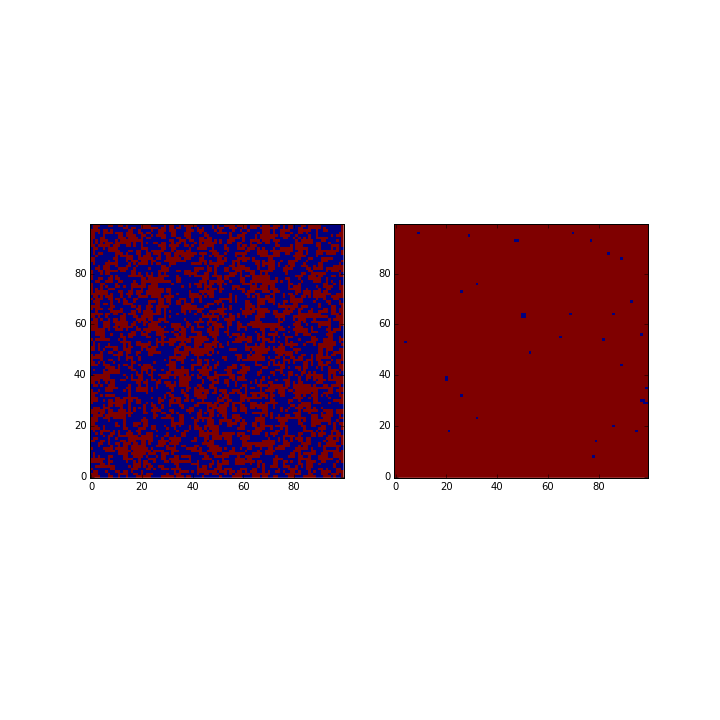
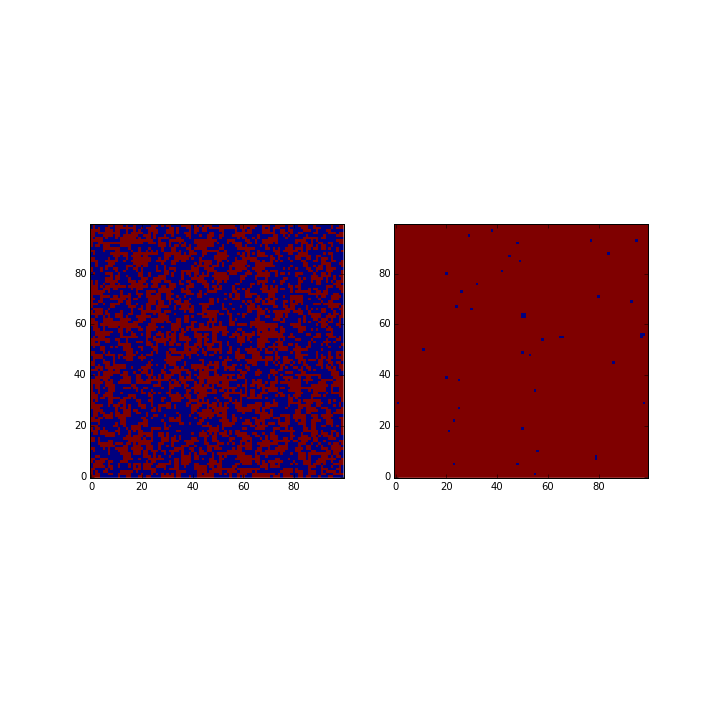
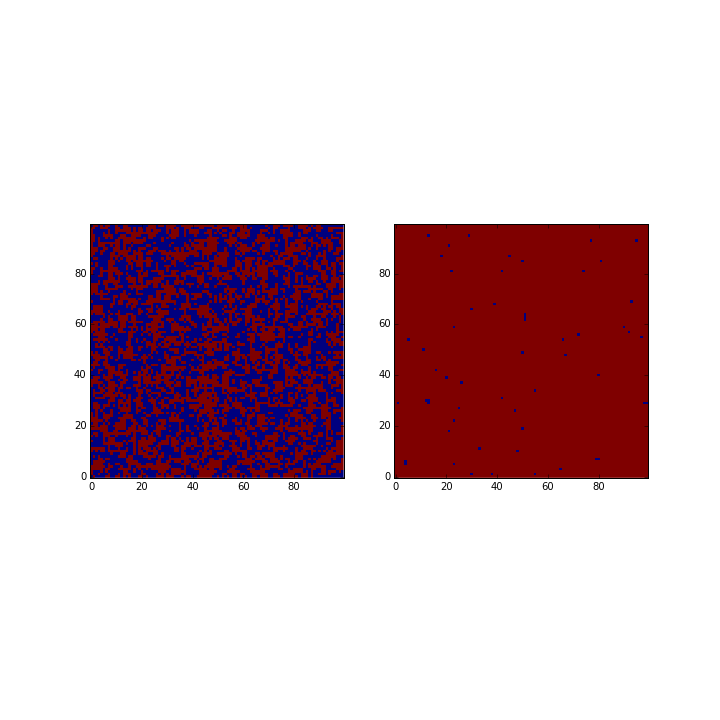
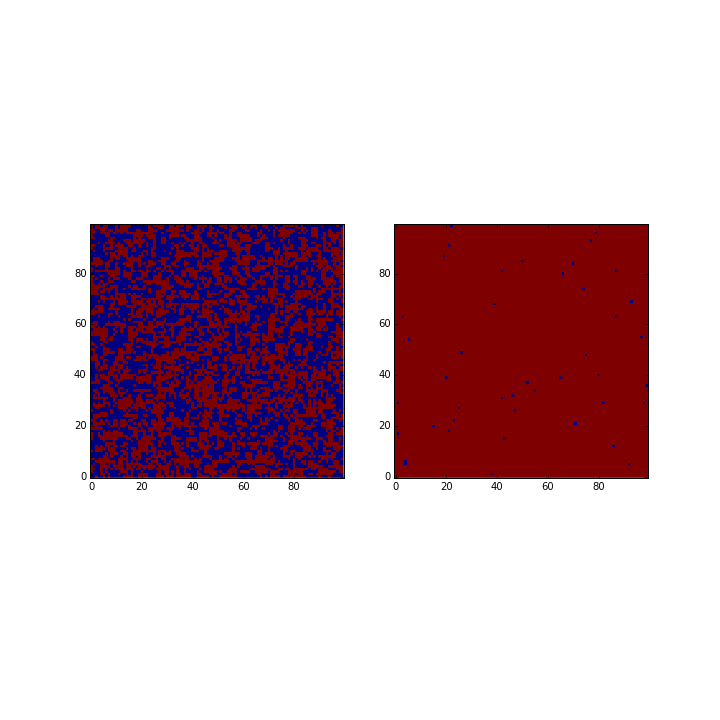
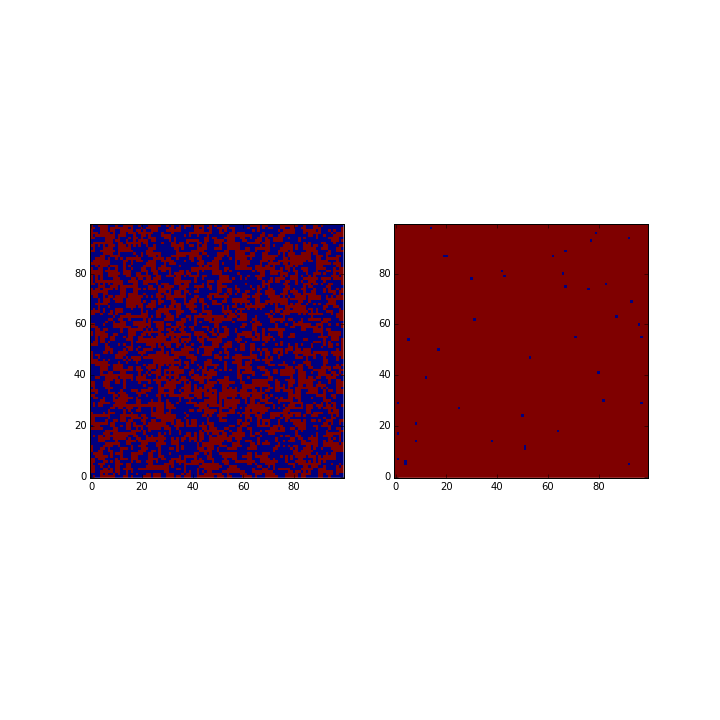
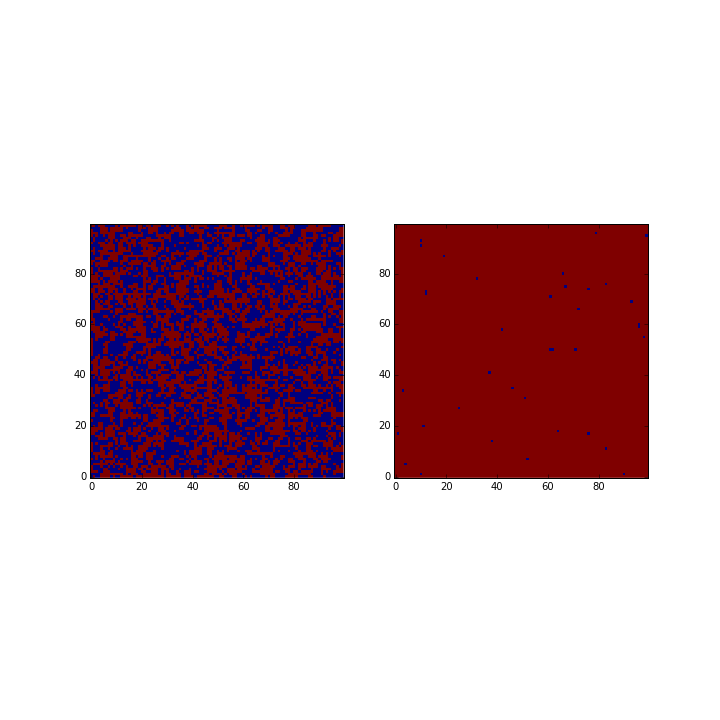
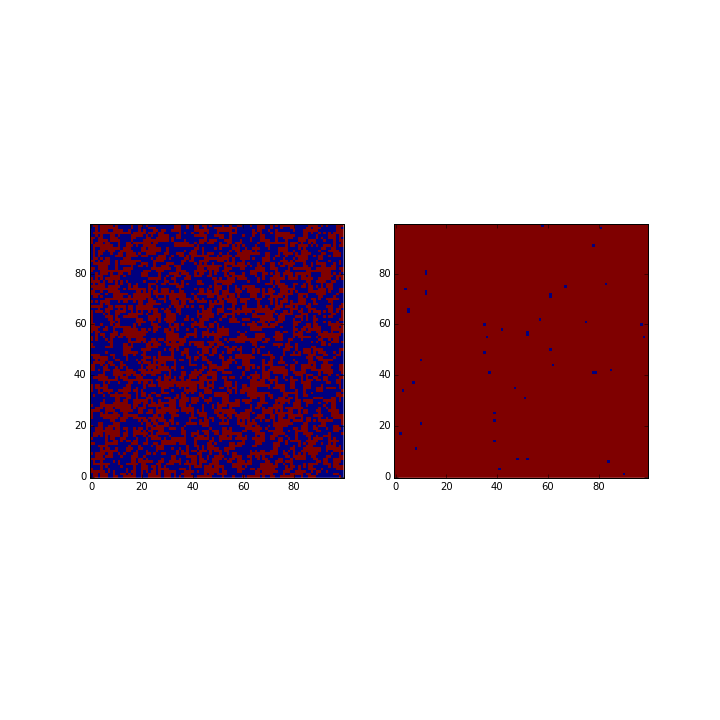
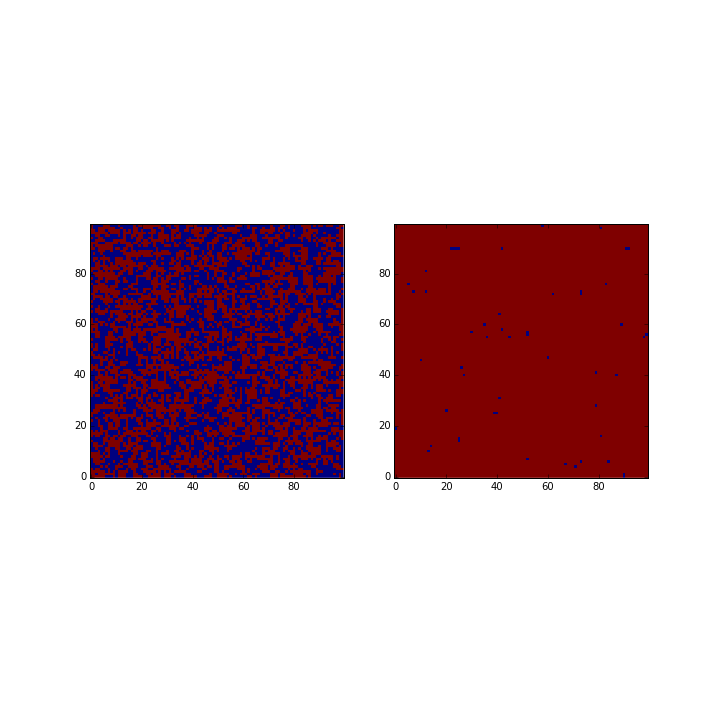
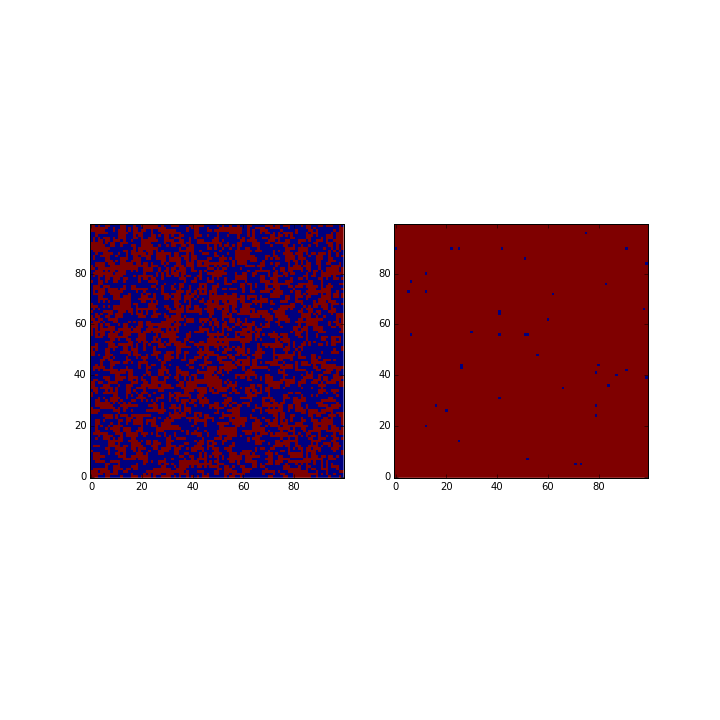
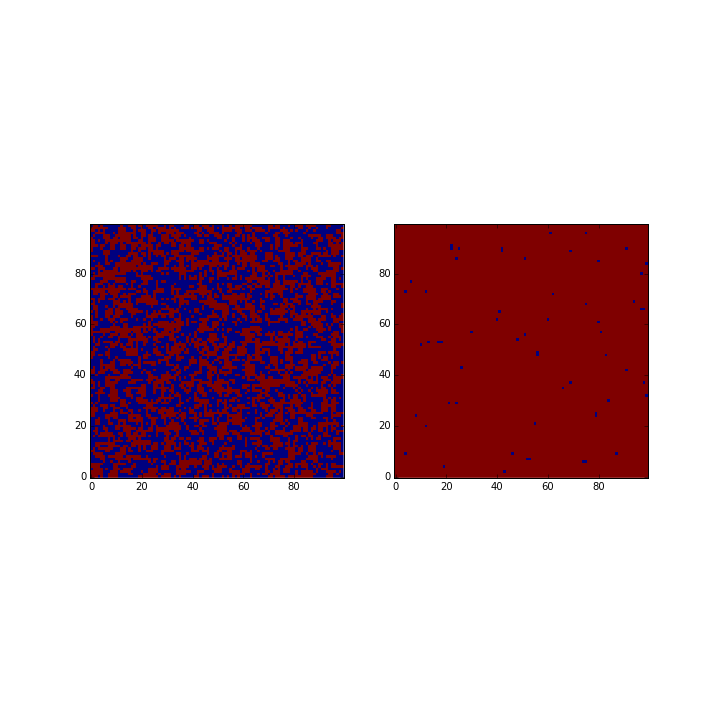
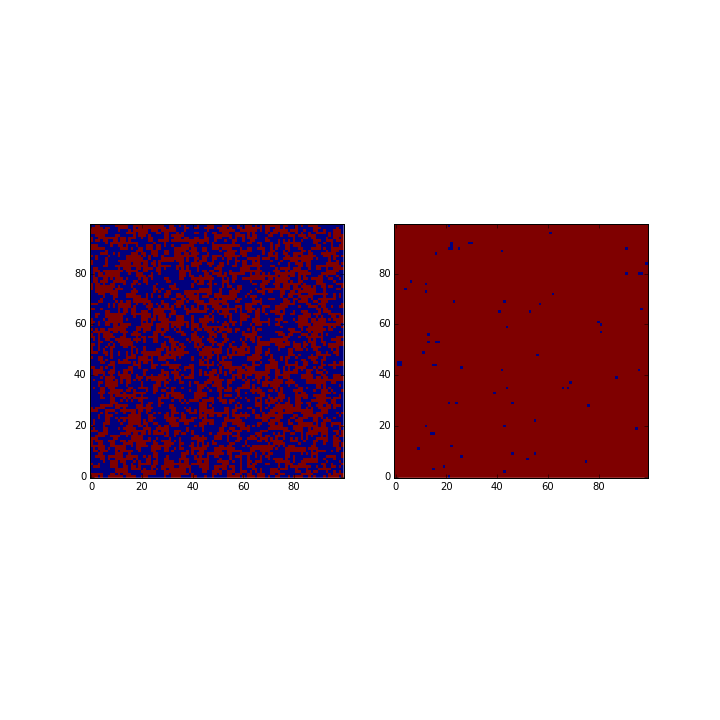
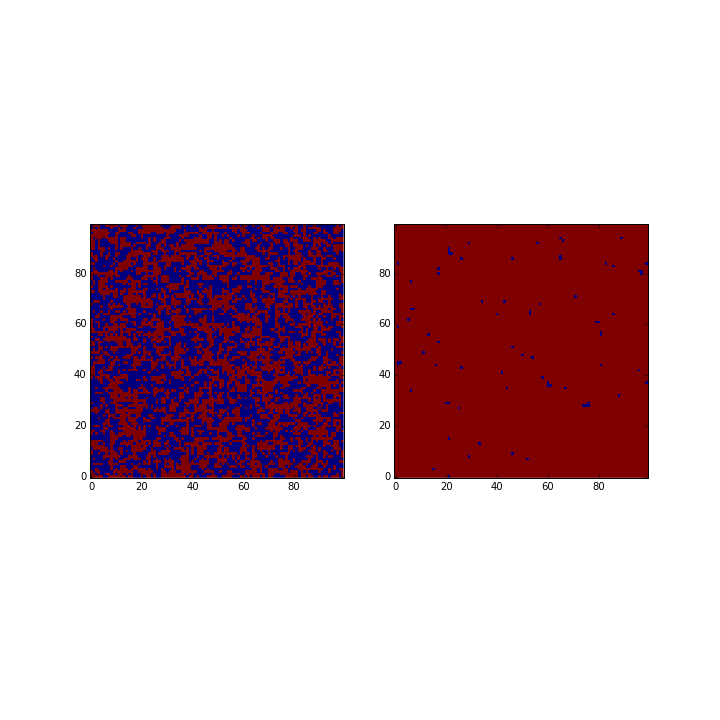
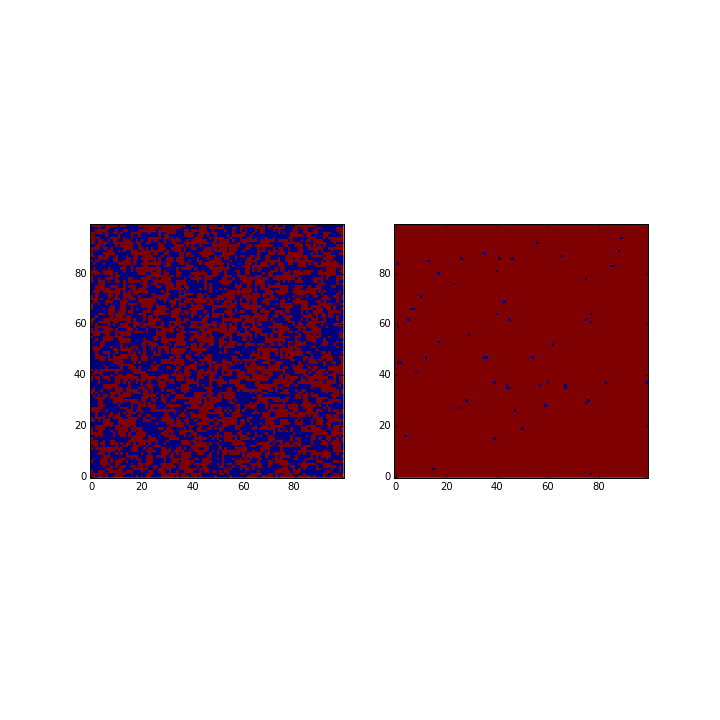
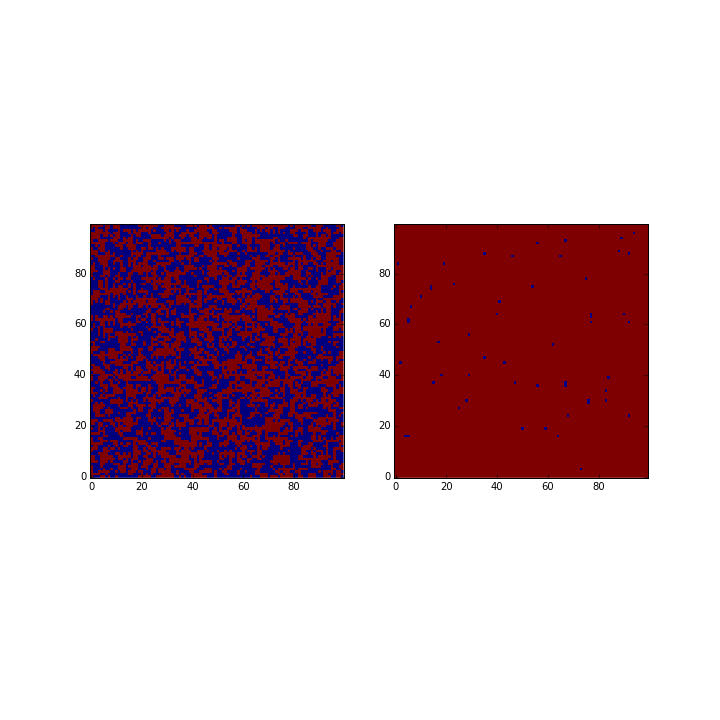
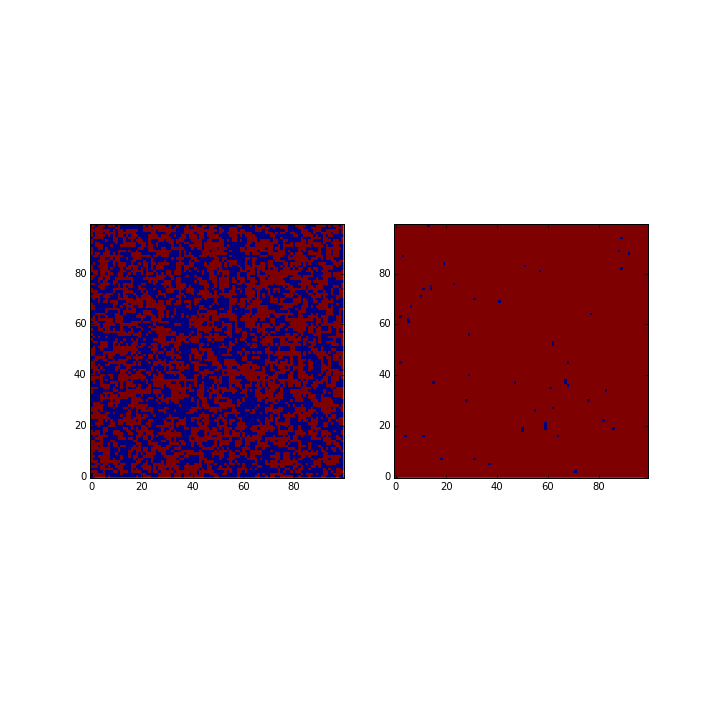
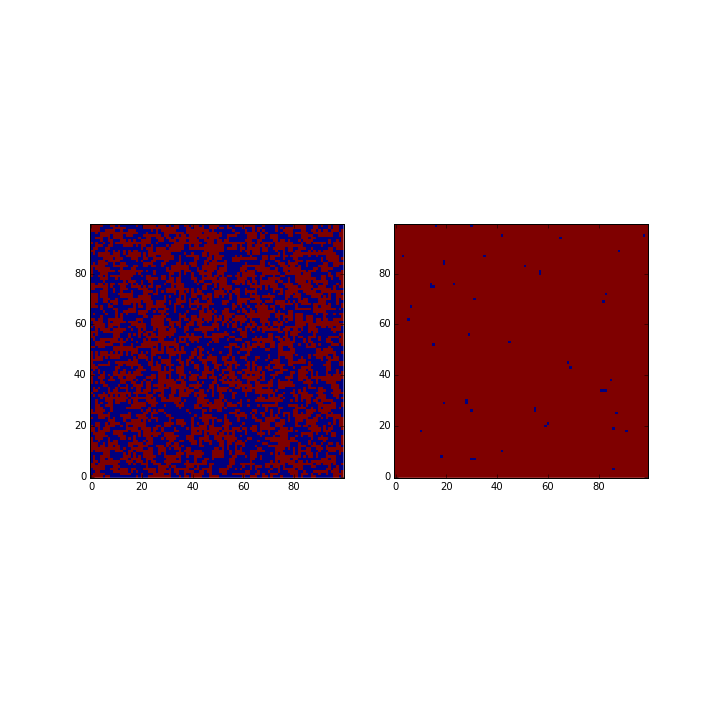
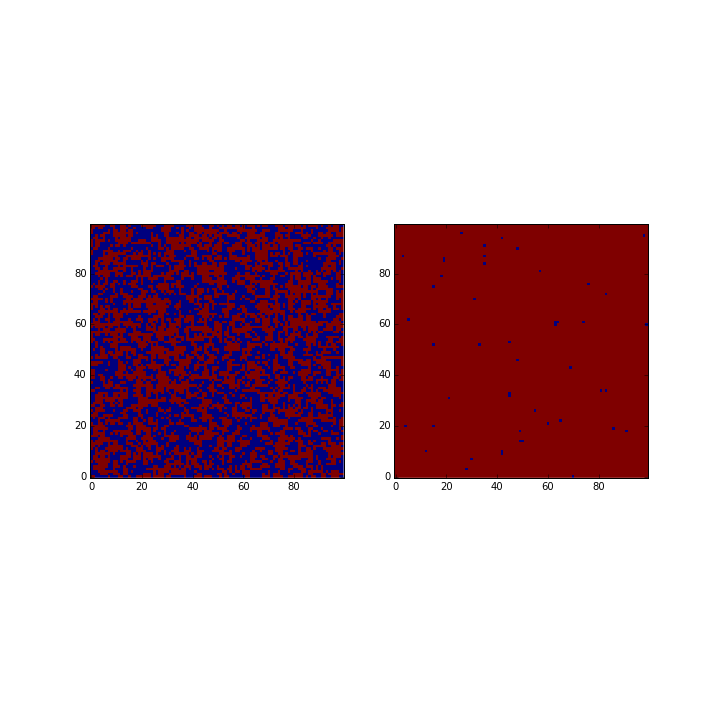
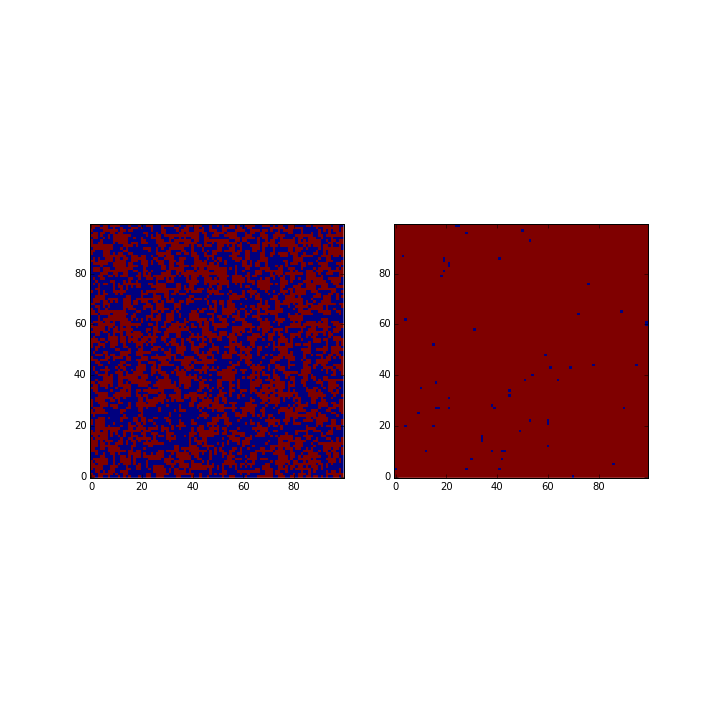
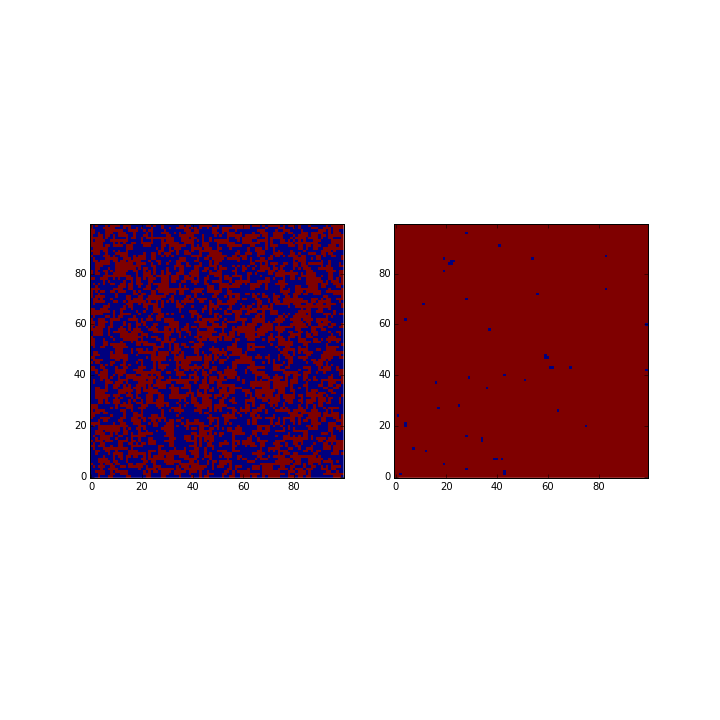
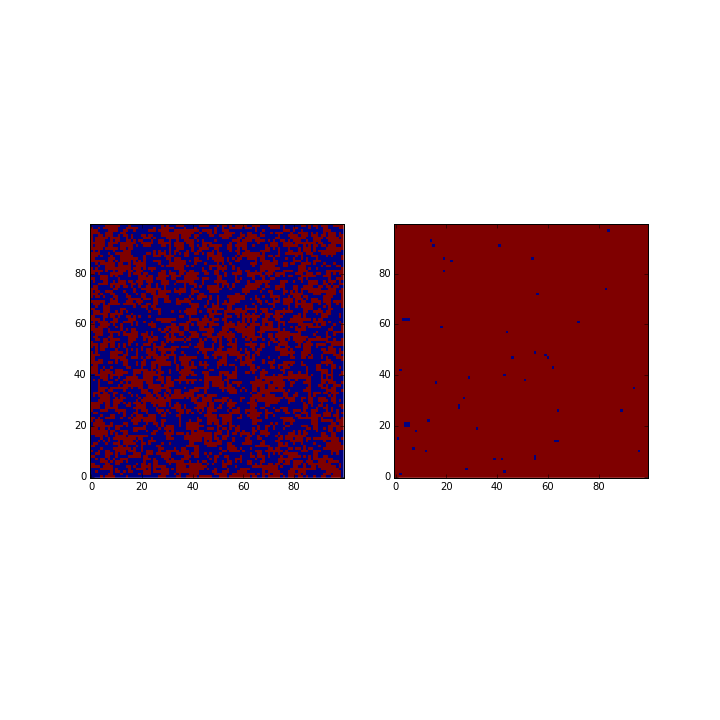
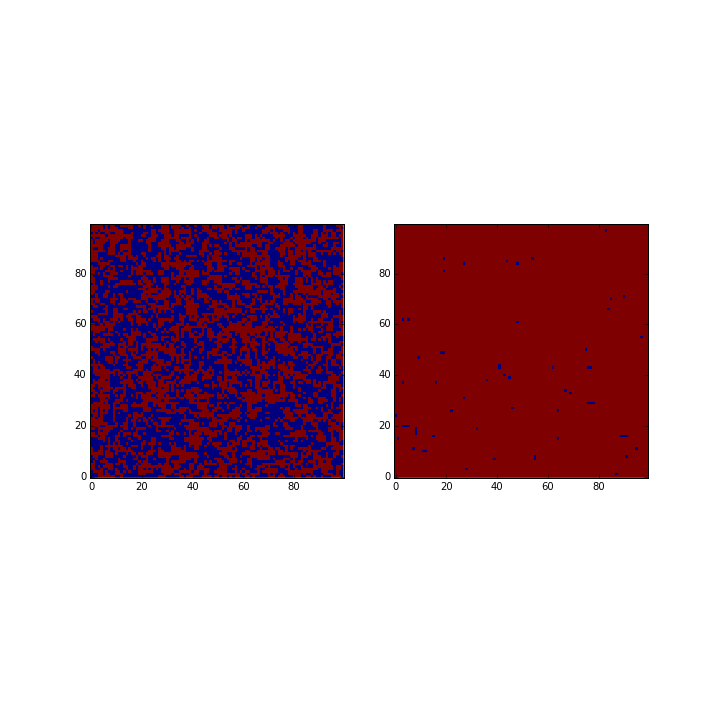
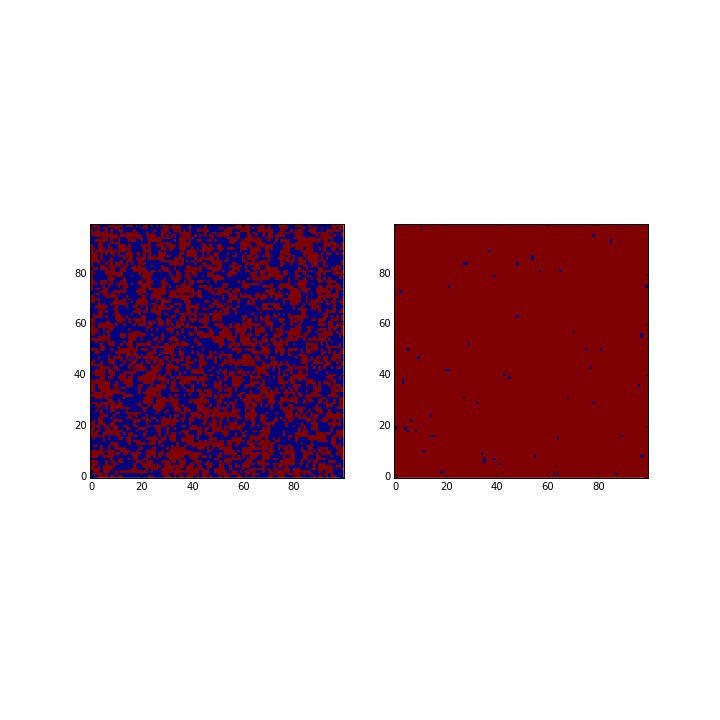
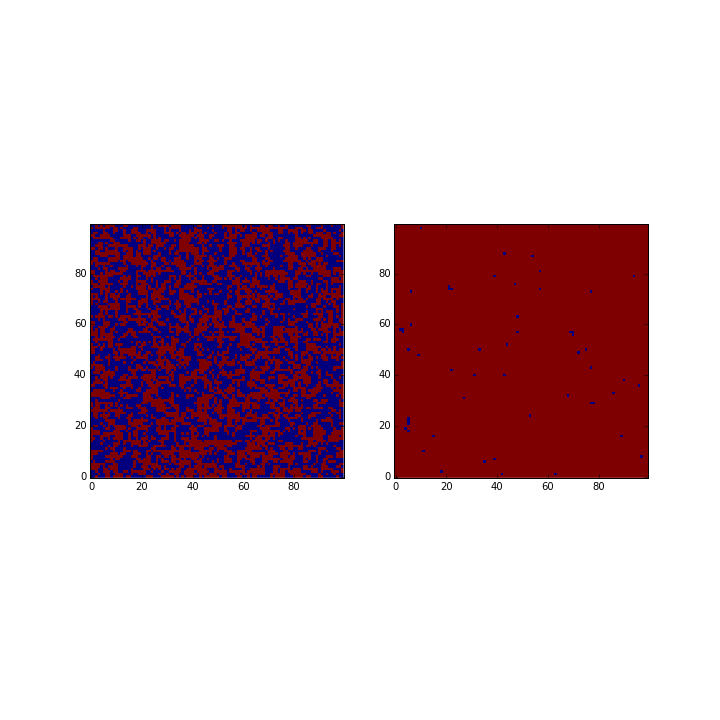
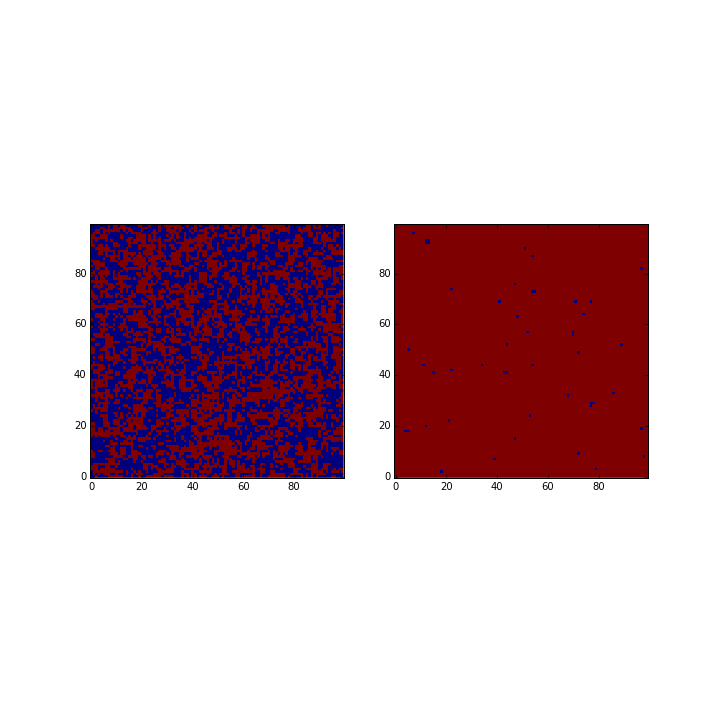
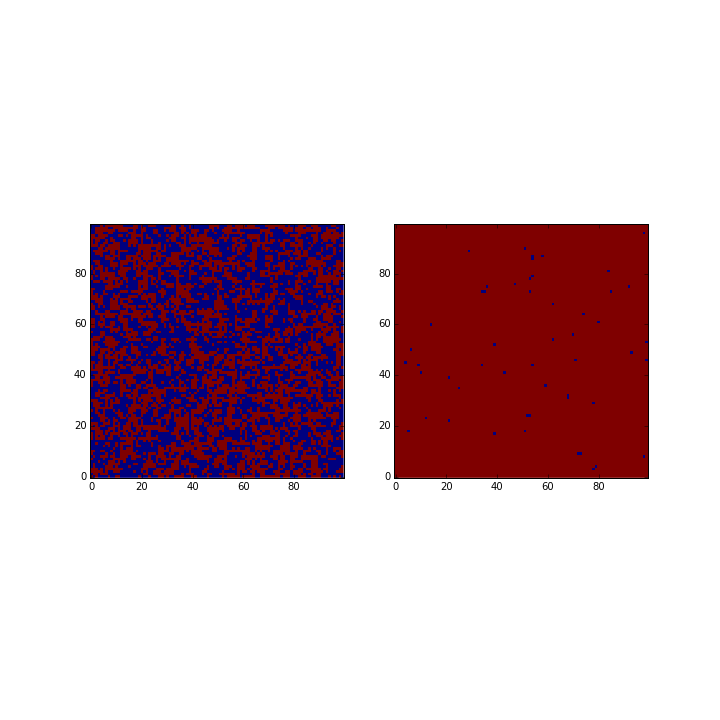
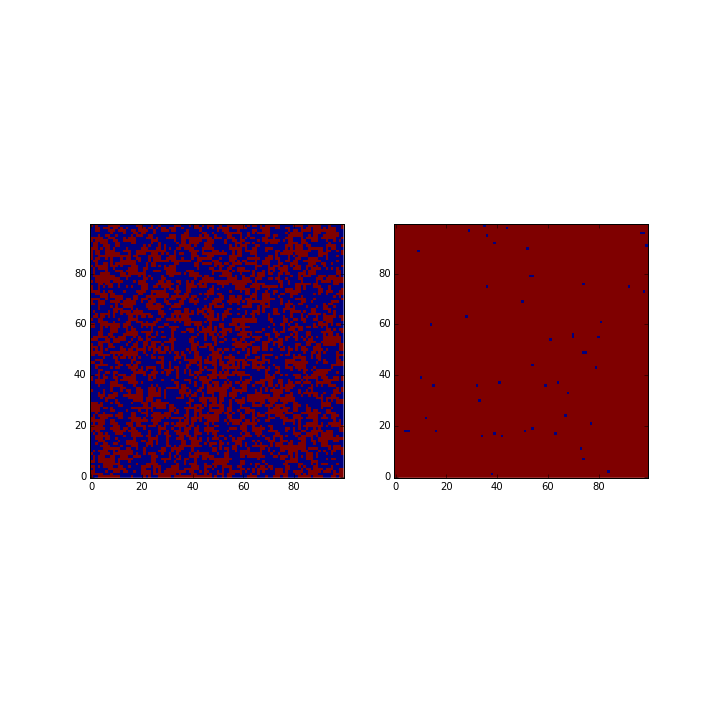
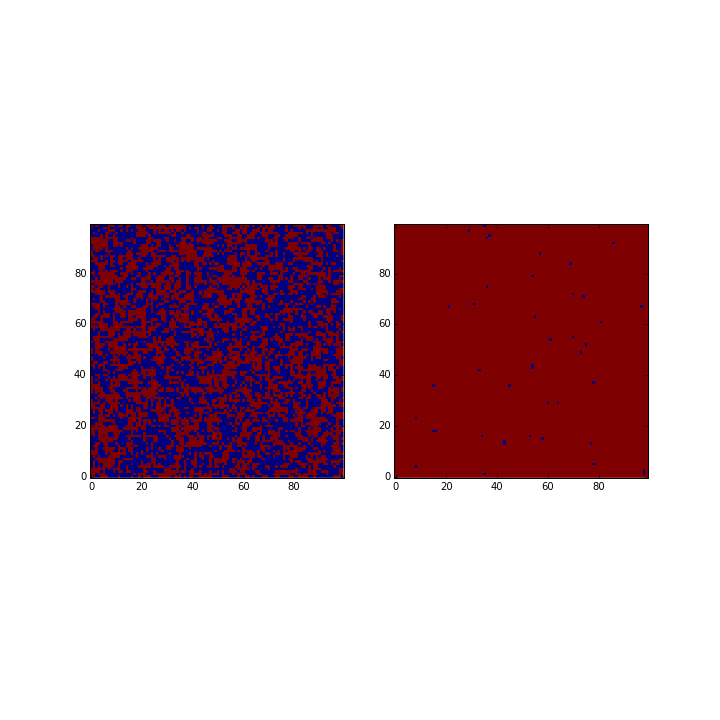
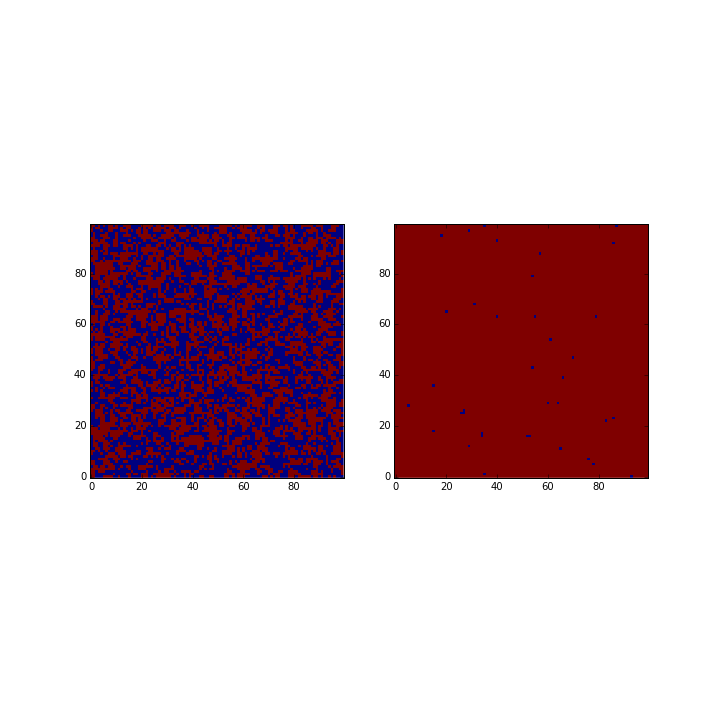
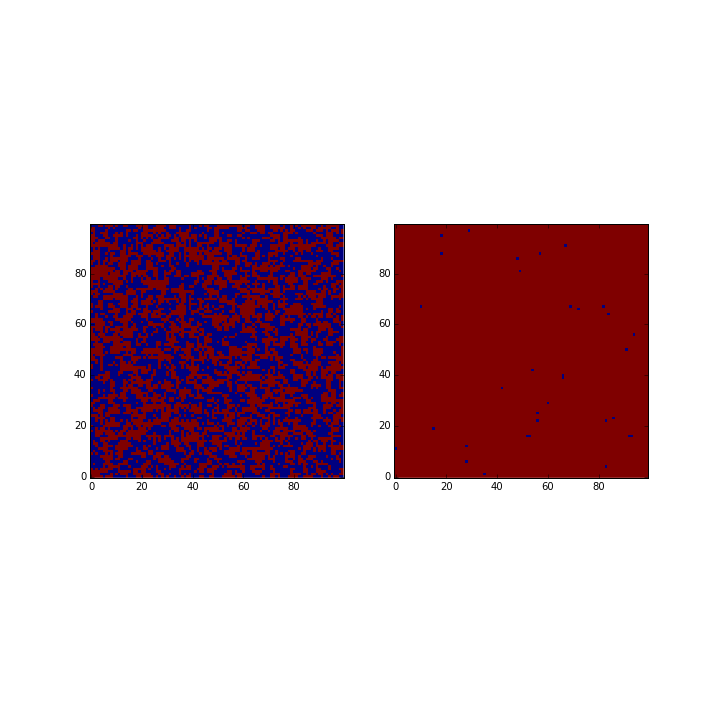
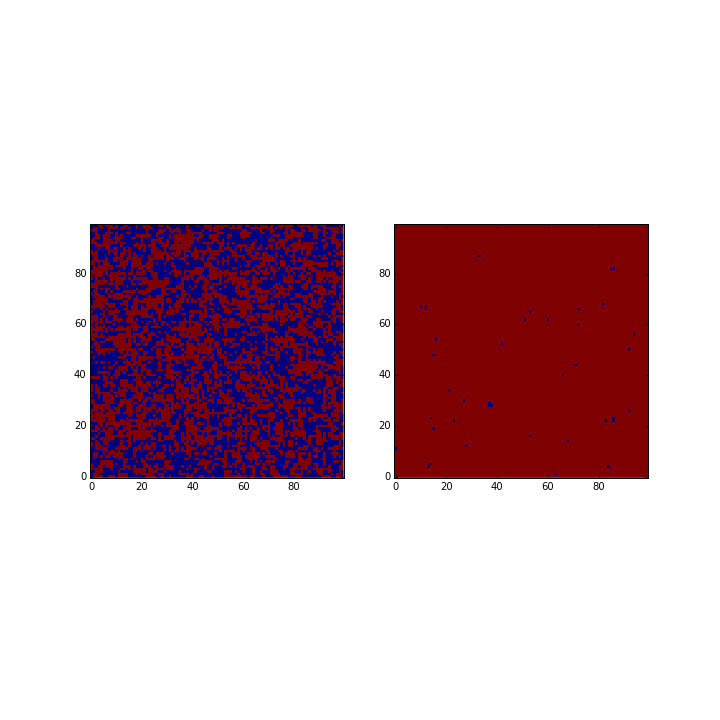
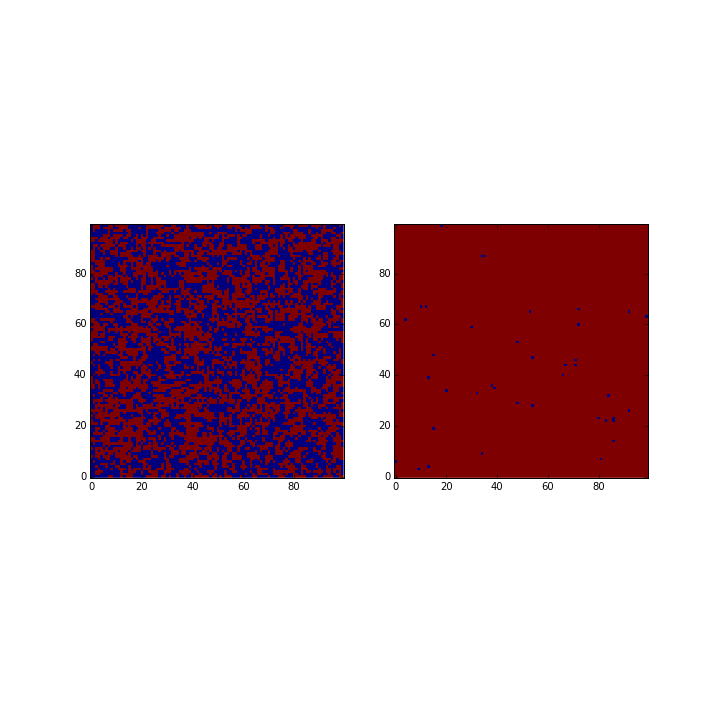
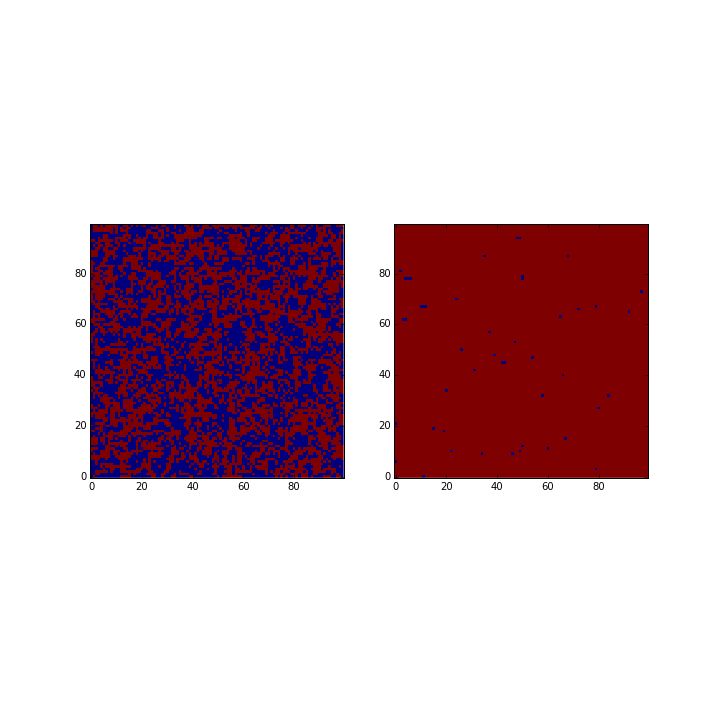
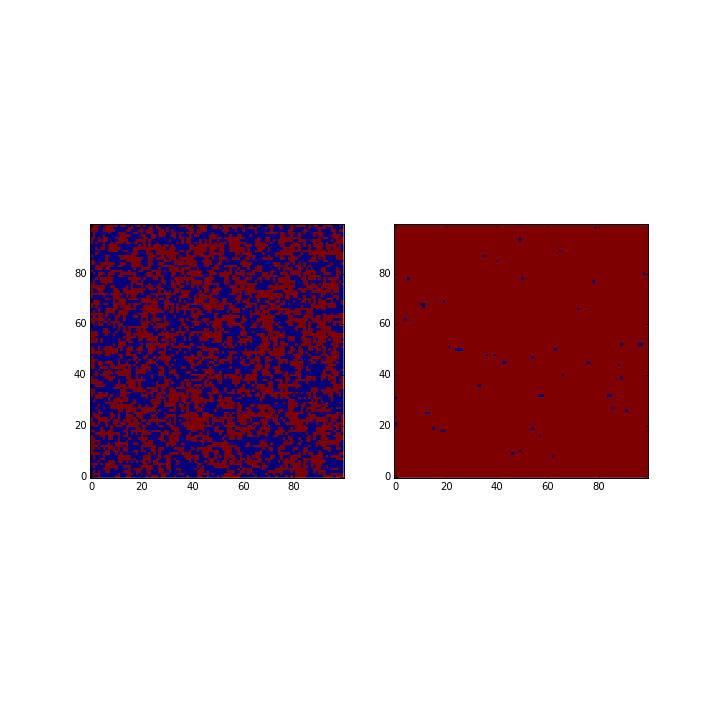
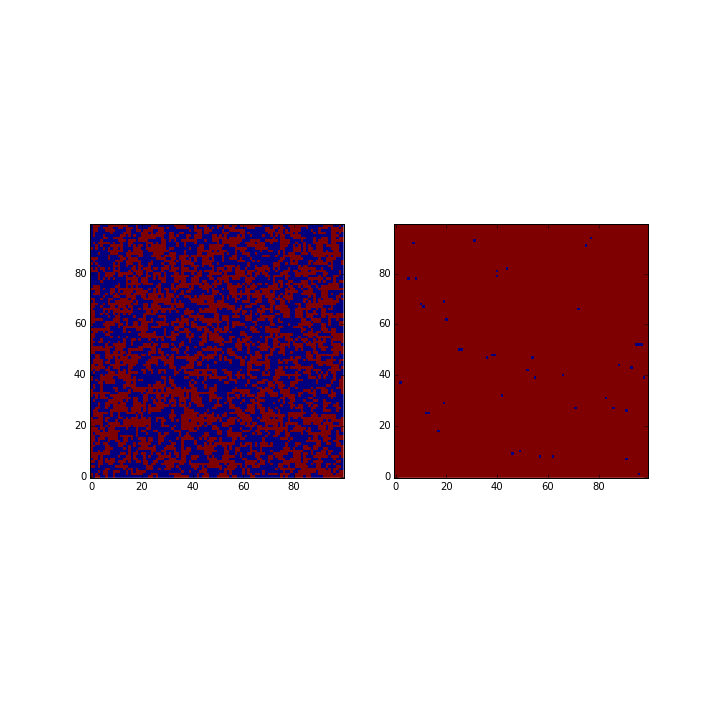
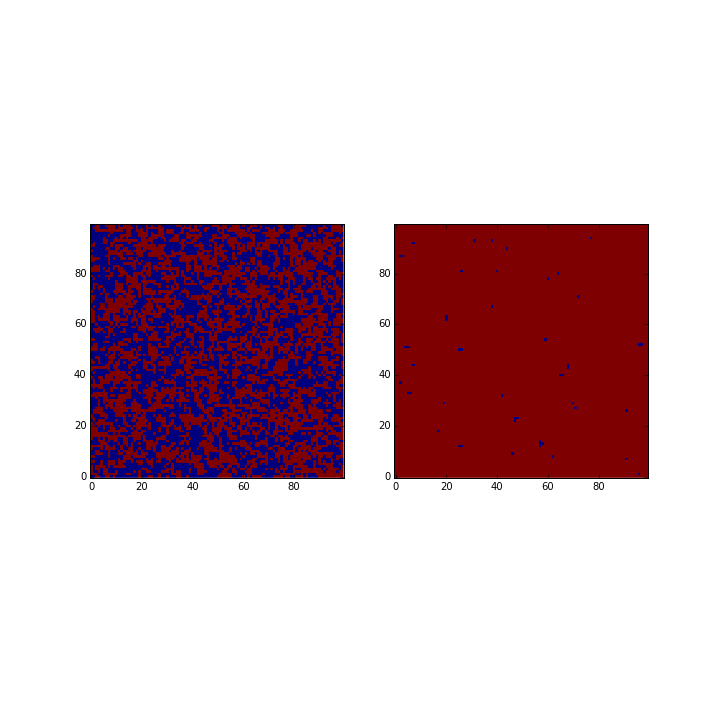
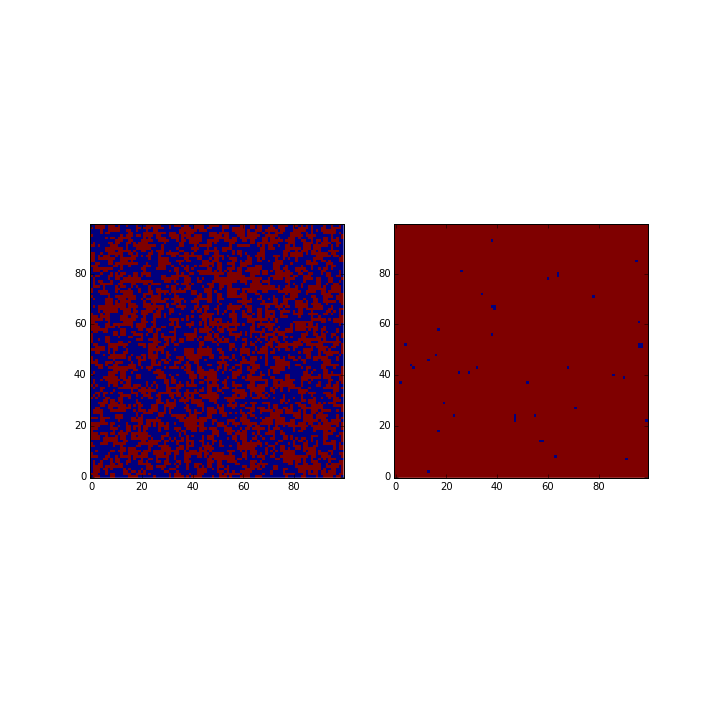
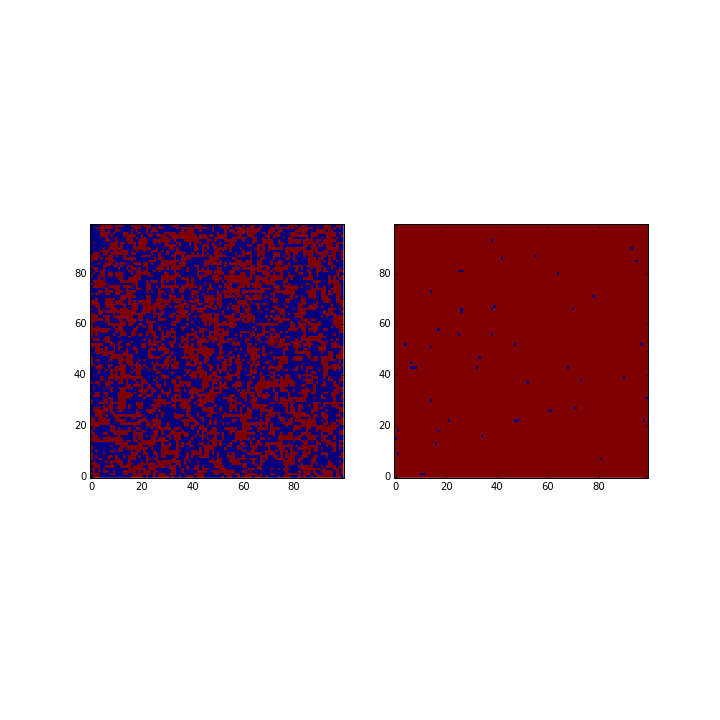
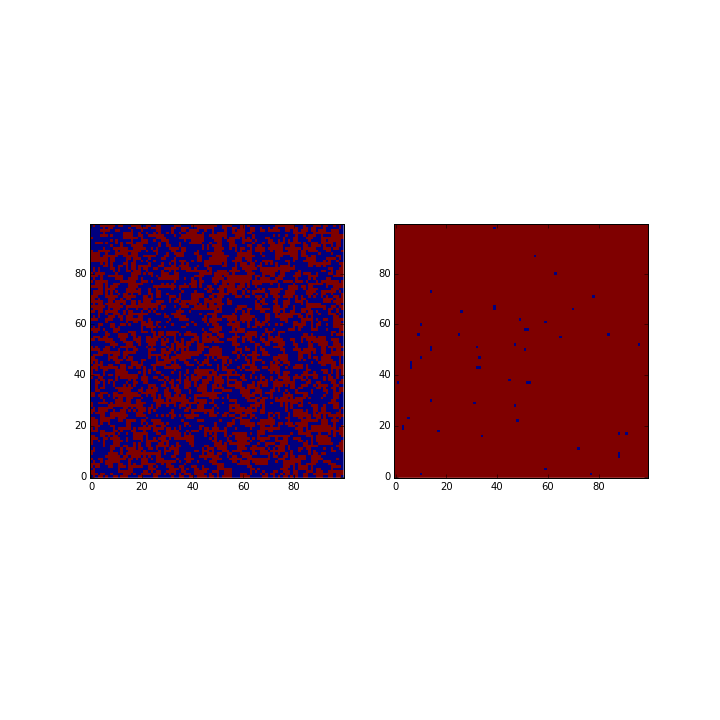

In [16]:
fig = pyplot.figure(figsize=(10,10))
pyplot.subplot(1, 2, 1)
img1 = pyplot.imshow(states_0_2[0],interpolation="none",origin='lower',\
                     vmin=-1, vmax=1)

pyplot.subplot(1, 2, 2)
img2 = pyplot.imshow(states_0_7[0],interpolation="none",origin='lower',\
                     vmin=-1, vmax=1)

# Animate
def animate(i):
    img1.set_array(states_0_2[i])
    img2.set_array(states_0_7[i])

animation.FuncAnimation(fig, animate, frames=NMC, interval=200)











Great! We see that for $\alpha=0.2$, the spins remain disorganised while for $\alpha=0.7$ the system remains nearly completely magnetized. Does this make sense according to the theory we have outlined at the beginning of the notebook? Let's also look at the evolution of the total spin (magnetisation) as the sequence is generated.

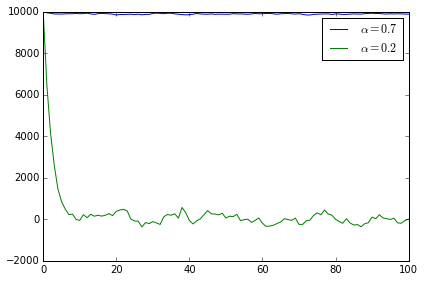

In [17]:
pyplot.figure()
pyplot.plot(states_0_7.sum(axis=(1,2)),label=r'$\alpha=0.7$')
pyplot.plot(states_0_2.sum(axis=(1,2)),label=r'$\alpha=0.2$')
pyplot.legend()
pyplot.tight_layout()

In both cases, the initial magnetisation is maximum. For $\alpha=0.2$, it rapidly decays and oscillates around a vanishing value; for $\alpha=0.7$, the magnetisation remains maxiumum. 

For $\alpha=2$, it takes a finite time before the system reaches a statistically steady state. In such case, when taking averages over the sequence of states to estimate a physical quantity, it might be necessary to sample more states and remove the initial ones which are far from equilibrium and that bias statistical averages. This is especially true close to the critical temperature as the magnetization decays rather slowly. 

## Challenge

- Perform a series of runs with $\alpha \in [0,1]$ and plot the average energy of the system and its magnetisation as a function of $\alpha$. Estimate the critical value of $\alpha$ at which the phase transition occurs. Is it compatible with Onsager's exact solution for the system?
- Redo the analysis with a different set of boundary conditions for the lattice and a different initial lattice configuration. For example, you could assume that on the borders all the spins are pointing upwards on the borders while they are randomly oriented in the bulk.

In [18]:
from IPython.core.display import HTML
css_file = '../../styles/numericalmoocstyle.css'
HTML(open(css_file, "r").read())

FileNotFoundError: [Errno 2] No such file or directory: '../../styles/numericalmoocstyle.css'

### Exercice 1:

In [25]:
# Non-dimensional coupling constant J/(kb*T)
alpha=numpy.random.random_sample()

NMC=100
sp = numpy.ones([nx,ny])

k=0
r[0]=
for k in range(1,10):
    def ising_model_metropolis(sp, NMC, nx, ny, alpha):
        states = numpy.empty([NMC+1,nx,ny])
        states[0] = sp.copy()
    
        for i in range(1,NMC+1):
            for j in range(0,nx*ny):
                ix=numpy.random.random_integers(0,nx-1)
                iy=numpy.random.random_integers(0,ny-1)
                metropolis_at_site(sp,alpha,ix,iy)
                states[i]=sp.copy()
        return states

r[l]=alpha    
k=k+1

print(r)


states=ising_model_metropolis(sp, NMC, nx, ny, alpha)
pyplot.plot(states.sum(axis=(1,2)))


NameError: name 'l' is not defined